In [1]:
#load libraries
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
from matplotlib.pyplot import figure
import re
from collections import Counter

# function to read data from a text file:

In [2]:
#This function simply reads a BEAR output text file with data and outputs it as a bunch of lists
def read_file(filename):
    #just declaring a list for each column
    phot_E = [] #eV
    I_KB = [] # INSTR_1, Kiethley B: instrument 1 with sample + bias, current
    I_KA = [] # INSTR_2, Kiethley A, instrument 2 (monitor)
    I_KC=[]

    copy_lines = []
    with open (filename, "r", encoding='windows-1254') as myfile: #encoding change resolves an error coming from an extra \n at the end of files
        for l in myfile: #read lines until first occurence of this long line

            if "______________________________________________" in l:
                break
        for l in myfile: #read the file again until this appears
            if "______________________________________________" in l:
                break

        for l in myfile: #from then on, read all non-empty lines and split them on tab
            if l != "\n":
                line = l.strip() 
                line = re.split(r'\t+', line)
                copy_lines.append(line)

    #from each line, extract a name/number and append it into its relevant column
    for i in range(1,len(copy_lines)-1):
        line = copy_lines[i]

        phot_E.append(line[1])
        I_KB.append(line[4])
        I_KA.append(line[5])
        I_KC.append(line[6])

    #extracted values are still strings --> cast numbers to floats
    for i in range(0, len(phot_E)):
        phot_E[i] = float(phot_E[i])
        I_KB[i] = float(I_KB[i])
        I_KA[i] = float(I_KA[i])
        I_KC[i] = float(I_KC[i])
    
    return([phot_E, I_KB, I_KA, I_KC])

In [3]:
def convert_eV_to_nm(energy_eV_list):
    # a simple function that takes a list with photon energy values (in eV) and converts them into wavelength (in nm)
    eV = 1.602e-19 #Joule, electronvolt
    h = 6.62607004e-34 #J*s, planck constant
    c = 2.99792e8 #m/s', speed of light
    wavelength_list = []
    for datapoint in energy_eV_list:
        energy_J = datapoint * eV
        wavelength_list.append(h*c/energy_J*1e9) #in nm
    return(wavelength_list)

In [4]:
def convert_nm_to_eV(nm_list):
    eV = 1.602e-19 #Joule, electronvolt
    h = 6.62607004e-34 #J*s, planck constant
    c = 2.99792e8 #m/s', speed of light
    eV_list = []
    for lambda_val in nm_list:
        energy_J = h*c/(lambda_val*1e-9)
        energy_eV = energy_J/eV
        eV_list.append(energy_eV) #in nm
    return(np.array(eV_list))

In [5]:
def calibrate_energy(E_val=float,coeff1_start=float,coeff1_benchmark=float,coeff1_stop=float,coeff0_start=float,coeff0_benchmark=float,coeff0_stop=float,start_eV=float,stop_eV=float):
    exp_wavelength = convert_eV_to_nm([E_val])[0]
    benchmark_eV = (start_eV+stop_eV)/2

    if E_val >= start_eV and E_val <= benchmark_eV:
        coeff0_used = coeff0_start + (coeff0_benchmark-coeff0_start)*(E_val-start_eV)/(benchmark_eV-start_eV)
        coeff1_used = coeff1_start + (coeff1_benchmark-coeff1_start)*(E_val-start_eV)/(benchmark_eV-start_eV)
    
    elif E_val > benchmark_eV and E_val <= stop_eV:
        coeff0_used = coeff0_benchmark + (coeff0_stop-coeff0_benchmark)*(E_val-benchmark_eV)/(stop_eV-benchmark_eV)
        coeff1_used = coeff1_benchmark + (coeff1_stop-coeff1_benchmark)*(E_val-benchmark_eV)/(stop_eV-benchmark_eV)
    else:
        #print("calibration error")
        return

    real_wavelength = coeff1_used*exp_wavelength + coeff0_used
    real_E_val = convert_nm_to_eV([real_wavelength])[0]
    return real_E_val

In [6]:
def get_region_df(reg_filename=str, reg_number=int, material_name=str):
    # function that takes a filename (textfile that should contain BEAR data with a single region), the region number and material name, and outputs a dataframe with the data
    reg = read_file(reg_filename) #call the readfile function (defined above) and store real time, photon energy, beamspot coordinates (x,y), and current readings (sample, monitor, BPM sum)
    #organize the data into the dataframe and return it
    reg_data = {'phot_E': reg[0], 'I_KB': reg[1], 'I_KA' : reg[2], 'I_KC': reg[3]}
    reg_df = pd.DataFrame(data=reg_data)
    reg_df['reg_number'] = reg_number
    reg_df['material_name'] = material_name

    #now the photon energy needs to be calibrated
    phot_E_exp = reg[1] #experimental photon energy
    phot_E_real = []

    for val in phot_E_exp:
        if val>46 and val<=73:
            new_val = calibrate_energy(E_val=val,coeff1_start=1,    coeff1_benchmark=0.993416, coeff1_stop=0.996,coeff0_start=0,   coeff0_benchmark=0.334699, coeff0_stop=0.30,start_eV=45, stop_eV=73)
        elif val>73 and val<=100:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.996,coeff1_benchmark=0.997869, coeff1_stop=0.82, coeff0_start=0.30,coeff0_benchmark=0.264657, coeff0_stop=0.9, start_eV=73, stop_eV=100)
        elif val>100 and val<=280:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.82, coeff1_benchmark=0.646822, coeff1_stop=0.36, coeff0_start=0.9, coeff0_benchmark=1.56458,  coeff0_stop=2.1, start_eV=100,stop_eV=280)
        elif val>280 and val<=390:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.36, coeff1_benchmark=0.0978598,coeff1_stop=0.077,coeff0_start=2.1, coeff0_benchmark=2.69488,  coeff0_stop=2.45,start_eV=280,stop_eV=390)
        elif val>390 and val<=515:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.077,coeff1_benchmark=0.0574908,coeff1_stop=-0.15,coeff0_start=2.45,coeff0_benchmark=2.14519,  coeff0_stop=2.66,start_eV=390,stop_eV=515)
        elif val>515 and val<=700:
            new_val = calibrate_energy(E_val=val,coeff1_start=-0.15,coeff1_benchmark=-0.333024,coeff1_stop=0.82, coeff0_start=2.66,coeff0_benchmark=3.1823,   coeff0_stop=1.2, start_eV=515,stop_eV=700)
        elif val>700:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.82,coeff1_benchmark=1.77932,   coeff1_stop=3.34, coeff0_start=1.2, coeff0_benchmark=-0.678785,coeff0_stop=-2.6,start_eV=700,stop_eV=1500)
        else:
            new_val = val
        
        phot_E_real.append(new_val)

    reg_df['phot_E_real'] = phot_E_real
    return(reg_df)

In [7]:
def concate_regions(file_number=int, N_of_regs=int, material_name=str,reject_regions=list,add_regions_from_files=list):
    repetitions = []
    for i in range(len(add_regions_from_files)):
        val = add_regions_from_files[i]
        val_count_sofar = Counter(add_regions_from_files[:i+1])[val]
        repetitions.append(val_count_sofar)

    all_regions = []
    ind = 0
    for i in range(1,N_of_regs+1): #counting regions from 1, not from 0 (following how the files are written!)
        if i not in reject_regions: #if a respective index didn't saturate (aka the data's good)
            append_this = get_region_df(reg_filename=f"20220317_arneodo/file(1)_Region {i}__" + "{:04d}".format(file_number) + ".txt",reg_number=i, material_name=material_name)
            all_regions.append(append_this) #append the dataframe to others
        else: #if a region did saturate (or shall be removed for some other reason)
            new_file_number = add_regions_from_files[ind]
            if new_file_number != 0: #if the new file is legit
                
                new_reg_ind = repetitions[ind] #substitute region numbering would start from 1 again
                append_this = get_region_df(reg_filename=f"20220317_arneodo/file(1)_Region {new_reg_ind}__" + "{:04d}".format(new_file_number) + ".txt",reg_number=i, material_name=material_name)
                all_regions.append(append_this) #append the dataframe to others
            ind += 1
    df = pd.concat(all_regions, ignore_index=True, sort=False) #combine all used regions
    return df

In [8]:
def concate_regions_old(file_number=int, N_of_regs=int, material_name=str,reject_regions=list,add_regions_from_files=list):
    repetitions = []
    for i in range(len(add_regions_from_files)):
        val = add_regions_from_files[i]
        val_count_sofar = Counter(add_regions_from_files[:i+1])[val]
        repetitions.append(val_count_sofar)

    all_regions = []
    ind = 0
    for i in range(1,N_of_regs+1): #counting regions from 1, not from 0 (following how the files are written!)
        if i not in reject_regions: #if a respective index didn't saturate (aka the data's good)
            append_this = get_region_df(reg_filename=f"20210802_arneodo/file(1)_Region {i}__" + "{:04d}".format(file_number) + ".txt",reg_number=i, material_name=material_name)
            all_regions.append(append_this) #append the dataframe to others
        else: #if a region did saturate (or shall be removed for some other reason)
            new_file_number = add_regions_from_files[ind]
            if new_file_number != 0: #if the new file is legit
                
                new_reg_ind = repetitions[ind] #substitute region numbering would start from 1 again
                append_this = get_region_df(reg_filename=f"20210802_arneodo/file(1)_Region {new_reg_ind}__" + "{:04d}".format(new_file_number) + ".txt",reg_number=i, material_name=material_name)
                all_regions.append(append_this) #append the dataframe to others
            ind += 1
    df = pd.concat(all_regions, ignore_index=True, sort=False) #combine all used regions
    return df

# Instrument 3 Dark (Keithley C)

Text(0, 0.5, 'dark photodiode current')

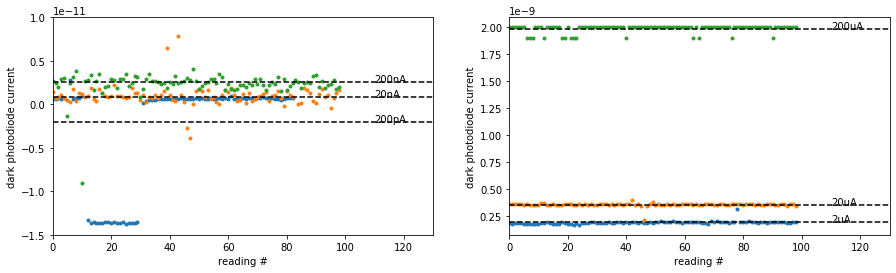

In [9]:
pd_dark_200pA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(58) + ".txt",reg_number=1, material_name='pd_dark_200pA')
pd_dark_20nA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(59) + ".txt",reg_number=1, material_name='pd_dark_20nA')
pd_dark_200nA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(60) + ".txt",reg_number=1, material_name='pd_dark_200nA')
pd_dark_2uA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(61) + ".txt",reg_number=1, material_name='pd_dark_2uA')
pd_dark_20uA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(62) + ".txt",reg_number=1, material_name='pd_dark_20uA')
pd_dark_200uA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(63) + ".txt",reg_number=1, material_name='pd_dark_200uA')

fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(pd_dark_200pA_df['I_KC'],'.')
pd_dark_200pA=np.mean(pd_dark_200pA_df['I_KC'])
plt1.axhline(y=pd_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=pd_dark_200pA)

plt1.plot(pd_dark_20nA_df['I_KC'],'.')
pd_dark_20nA=np.mean(pd_dark_20nA_df['I_KC'])
plt1.axhline(y=pd_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=pd_dark_20nA)

plt1.plot(pd_dark_200nA_df['I_KC'],'.')
pd_dark_200nA=np.mean(pd_dark_200nA_df['I_KC'])
plt1.axhline(y=pd_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=pd_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_ylim(-1.5e-11,1e-11)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark photodiode current')

plt2.plot(pd_dark_2uA_df['I_KC'],'.')
pd_dark_2uA=np.mean(pd_dark_2uA_df['I_KC'])
plt2.axhline(y=pd_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=pd_dark_2uA)

plt2.plot(pd_dark_20uA_df['I_KC'],'.')
pd_dark_20uA=np.mean(pd_dark_20uA_df['I_KC'])
plt2.axhline(y=pd_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=pd_dark_20uA)

plt2.plot(pd_dark_200uA_df['I_KC'],'.')
pd_dark_200uA=np.mean(pd_dark_200uA_df['I_KC'])
plt2.axhline(y=pd_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=pd_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark photodiode current')


# Keithley A (monitor) Dark

Text(0, 0.5, 'dark monitor (KA) current')

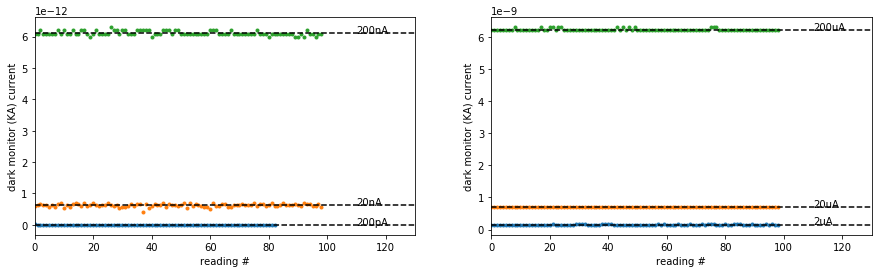

In [10]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(pd_dark_200pA_df['I_KA'],'.')
KA_dark_200pA=np.mean(pd_dark_200pA_df['I_KA'])
plt1.axhline(y=KA_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=KA_dark_200pA)

plt1.plot(pd_dark_20nA_df['I_KA'],'.')
KA_dark_20nA=np.mean(pd_dark_20nA_df['I_KA'])
plt1.axhline(y=KA_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=KA_dark_20nA)

plt1.plot(pd_dark_200nA_df['I_KA'],'.')
KA_dark_200nA=np.mean(pd_dark_200nA_df['I_KA'])
plt1.axhline(y=KA_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=KA_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark monitor (KA) current')

plt2.plot(pd_dark_2uA_df['I_KA'],'.')
KA_dark_2uA=np.mean(pd_dark_2uA_df['I_KA'])
plt2.axhline(y=KA_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=KA_dark_2uA)

plt2.plot(pd_dark_20uA_df['I_KA'],'.')
KA_dark_20uA=np.mean(pd_dark_20uA_df['I_KA'])
plt2.axhline(y=KA_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=KA_dark_20uA)

plt2.plot(pd_dark_200uA_df['I_KA'],'.')
KA_dark_200uA=np.mean(pd_dark_200uA_df['I_KA'])
plt2.axhline(y=KA_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=KA_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark monitor (KA) current')

# Keithley B (sample) Dark

Text(0, 0.5, 'dark sample (KB) current')

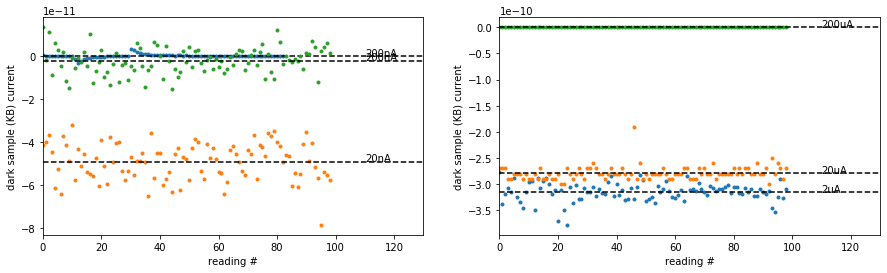

In [11]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(pd_dark_200pA_df['I_KB'],'.')
KB_dark_200pA=np.mean(pd_dark_200pA_df['I_KB'])
plt1.axhline(y=KB_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=KB_dark_200pA)

plt1.plot(pd_dark_20nA_df['I_KB'],'.')
KB_dark_20nA=np.mean(pd_dark_20nA_df['I_KB'])
plt1.axhline(y=KB_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=KB_dark_20nA)

plt1.plot(pd_dark_200nA_df['I_KB'],'.')
KB_dark_200nA=np.mean(pd_dark_200nA_df['I_KB'])
plt1.axhline(y=KB_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=KB_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark sample (KB) current')

plt2.plot(pd_dark_2uA_df['I_KB'],'.')
KB_dark_2uA=np.mean(pd_dark_2uA_df['I_KB'])
plt2.axhline(y=KB_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=KB_dark_2uA)

plt2.plot(pd_dark_20uA_df['I_KB'],'.')
KB_dark_20uA=np.mean(pd_dark_20uA_df['I_KB'])
plt2.axhline(y=KB_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=KB_dark_20uA)

plt2.plot(pd_dark_200uA_df['I_KB'],'.')
KB_dark_200uA=np.mean(pd_dark_200uA_df['I_KB'])
plt2.axhline(y=KB_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=KB_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark sample (KB) current')

# Summary of recorded (dark) current offsets:

In [12]:
offsets_data = {'range': ["200pA",'20nA','200nA','2uA','20uA','200uA'], 'KA_offset': [KA_dark_200pA,KA_dark_20nA,KA_dark_200nA,KA_dark_2uA,KA_dark_20uA,KA_dark_200uA], 'KB_offset' : [KB_dark_200pA,KB_dark_20nA,KB_dark_200nA,KB_dark_2uA,KB_dark_20uA,KB_dark_200uA], 'KC_offset': [pd_dark_200pA,pd_dark_20nA,pd_dark_200nA,pd_dark_2uA,pd_dark_20uA,pd_dark_200uA]}
offsets_df = pd.DataFrame(data=offsets_data)
offsets_df

,range,KA_offset,KB_offset,KC_offset
0,200pA,4.385542e-16,3.128313e-14,-2.042240e-12
1,20nA,6.252525e-13,-4.916333e-11,8.050505e-13
2,200nA,6.122222e-12,-2.214141e-12,2.602020e-12
3,2uA,1.529899e-10,-3.148990e-10,1.918485e-10
4,20uA,7.010101e-10,-2.784848e-10,3.545455e-10
5,200uA,6.213131e-09,0.000000e+00,1.985859e-09


# Function to subtract dark offsets from each dataframe:

In [13]:
def subtract_offsets(df_sample,sensvals,df_offsets):
    length = len(df_sample['phot_E'])
    df_sample['KA_offset'] = np.zeros(length)
    df_sample['KB_offset'] = np.zeros(length)
    df_sample['KC_offset'] = np.zeros(length)

    df_copy = df_sample # I iterate over original dataframe but I write into its copy
    for i in range(len(df_sample)): #iterate over the rows of sample dataframe
        row = df_sample.iloc[[i]] #copy a single row
        reg_number = int(row['reg_number'].tolist()[0])

        if '200pA' in sensvals[reg_number-1][0]: #ASSIGNING KA RANGE
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[0]['KA_offset']
        elif '20nA' in sensvals[reg_number-1][0]:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[1]['KA_offset']
        elif '200nA' in sensvals[reg_number-1][0]:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[2]['KA_offset']
        elif '2uA' in sensvals[reg_number-1][0]:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[3]['KA_offset']
        elif '20uA' in sensvals[reg_number-1][0]:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[4]['KA_offset']
        elif '200uA' in sensvals[reg_number-1][0]:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[5]['KA_offset']
        else: print("KA range not found!")

        if '200pA' in sensvals[reg_number-1][1]: #ASSIGNING KB RANGE
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[0]['KB_offset']
        elif '20nA' in sensvals[reg_number-1][1]:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[1]['KB_offset']
        elif '200nA' in sensvals[reg_number-1][1]:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[2]['KB_offset']
        elif '2uA' in sensvals[reg_number-1][1]:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[3]['KB_offset']
        elif '20uA' in sensvals[reg_number-1][1]:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[4]['KB_offset']
        elif '200uA' in sensvals[reg_number-1][1]:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[5]['KB_offset']
        else: print("KB range not found!")

        if '200pA' in sensvals[reg_number-1][2]: #ASSIGNING KC RANGE
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[0]['KC_offset']
        elif '20nA' in sensvals[reg_number-1][2]:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[1]['KC_offset']
        elif '200nA' in sensvals[reg_number-1][2]:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[2]['KC_offset']
        elif '2uA' in sensvals[reg_number-1][2]:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[3]['KC_offset']
        elif '20uA' in sensvals[reg_number-1][2]:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[4]['KC_offset']
        elif '200uA' in sensvals[reg_number-1][2]:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[5]['KC_offset']
        else: print("KC range not found!")

    df_sample = df_copy
    df_sample['I_KA_real'] = df_sample['I_KA'] - df_sample['KA_offset']
    df_sample['I_KB_real'] = df_sample['I_KB'] - df_sample['KB_offset']
    df_sample['I_KC_real'] = df_sample['I_KC'] - df_sample['KC_offset']

    return

# Plot and polyfit of the Photodiode's responsivity function (MARCH 2022):

/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(350, 1500)

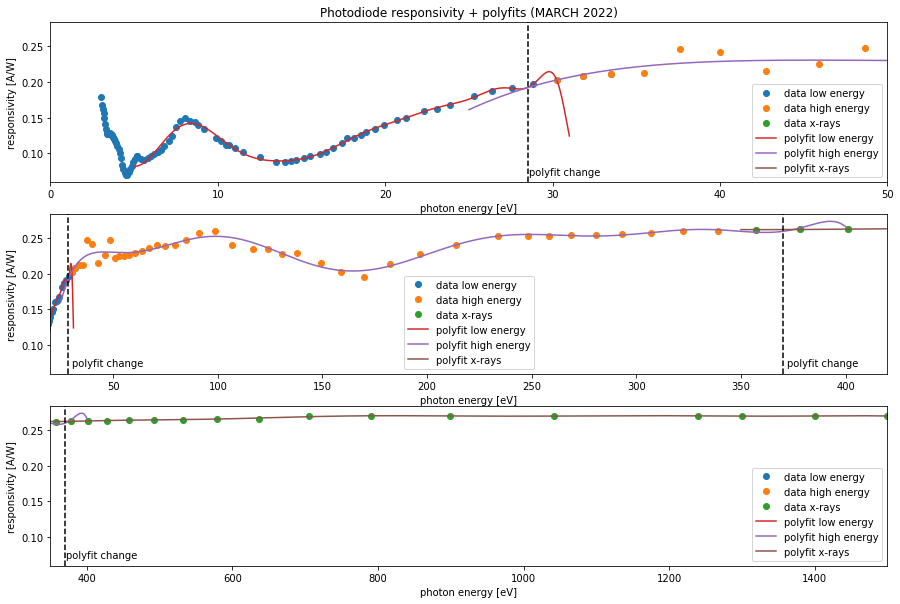

In [14]:
ph_eV, wavelength_nm, responsivity = [],[],[] # load photodiode responsivity from a textfile:

filename = "axuv_responsivity.txt"
startline = 3 #first two lines are useless

copy_lines=[]
with open(filename) as f:
    lines = f.readlines()

for line in lines:
    split_line = line.split()
    copy_lines.append(split_line)

for i in range(startline-1,len(copy_lines)-1): #from each line, extract a name/number and append it into its relevant column
    line = copy_lines[i]
    ph_eV.append(float(line[0]))
    wavelength_nm.append(float(line[1]))
    responsivity.append(float(line[3]))

pd_data = {'phot_E': ph_eV, 'wavelength': wavelength_nm, 'responsivity' : responsivity}
responsivity_df_march = pd.DataFrame(data=pd_data).sort_values('phot_E')
cond1 = responsivity_df_march['phot_E'] <= 35
cond2 = responsivity_df_march['phot_E'] > 3
cond3 = responsivity_df_march['phot_E'] > 30
cond4 = responsivity_df_march['phot_E'] <= 420
cond5 = responsivity_df_march['phot_E'] > 350
energy_eV_march_low = responsivity_df_march[cond1 & cond2]['phot_E'].tolist()
energy_eV_march_high = responsivity_df_march[cond3 & cond4]['phot_E'].tolist()
energy_eV_march_xray = responsivity_df_march[cond5]['phot_E'].tolist()
responsivity_march_low = responsivity_df_march[cond1 & cond2]['responsivity'].tolist()
responsivity_march_high = responsivity_df_march[cond3 & cond4]['responsivity'].tolist()
responsivity_march_xray = responsivity_df_march[cond5]['responsivity'].tolist()

responsivity_fit_march_low = np.poly1d(np.polyfit(energy_eV_march_low, responsivity_march_low, 25)) #make a polynomial fit for the first region
responsivity_fit_march_high = np.poly1d(np.polyfit(energy_eV_march_high, responsivity_march_high, 10)) #make a polynomial fit for the first region
responsivity_fit_march_xray = np.poly1d(np.polyfit(energy_eV_march_xray, responsivity_march_xray, 10)) #make a polynomial fit for the first region

test_eV_low = np.linspace(5,31,1000)
test_eV_high = np.linspace(25,400,10000)
test_eV_xray = np.linspace(350,1500,10000)

thresh_1_march = 28.5 #photon energies (thresholds) at which polyfit needs to be changed
thresh_2_march = 370

fig, (plt1, plt2, plt3) = plt.subplots(3, 1, figsize=(15,10))

plt1.set_xlabel('photon energy [eV]')
plt1.set_ylabel('responsivity [A/W]')
plt1.set_title('Photodiode responsivity + polyfits (MARCH 2022)')
plt1.plot(energy_eV_march_low,responsivity_march_low,'o',label='data low energy')
plt1.plot(energy_eV_march_high,responsivity_march_high,'o',label='data high energy')
plt1.plot(energy_eV_march_xray,responsivity_march_xray,'o',label='data x-rays')
plt1.plot(test_eV_low, responsivity_fit_march_low(test_eV_low), '-',label='polyfit low energy')
plt1.plot(test_eV_high, responsivity_fit_march_high(test_eV_high), '-',label='polyfit high energy')
plt1.plot(test_eV_xray, responsivity_fit_march_xray(test_eV_xray), '-',label='polyfit x-rays')
plt1.axvline(x=thresh_1_march,linestyle='--',color='black')
plt1.text(s='polyfit change',x=thresh_1_march+0.1,y=0.07)
plt1.legend()
plt1.set_xlim(0,50)

plt2.set_xlabel('photon energy [eV]')
plt2.set_ylabel('responsivity [A/W]')
plt2.plot(energy_eV_march_low,responsivity_march_low,'o',label='data low energy')
plt2.plot(energy_eV_march_high,responsivity_march_high,'o',label='data high energy')
plt2.plot(energy_eV_march_xray,responsivity_march_xray,'o',label='data x-rays')
plt2.plot(test_eV_low, responsivity_fit_march_low(test_eV_low), '-',label='polyfit low energy')
plt2.plot(test_eV_high, responsivity_fit_march_high(test_eV_high), '-',label='polyfit high energy')
plt2.plot(test_eV_xray, responsivity_fit_march_xray(test_eV_xray), '-',label='polyfit x-rays')
plt2.axvline(x=thresh_1_march,linestyle='--',color='black')
plt2.axvline(x=thresh_2_march,linestyle='--',color='black')
plt2.text(s='polyfit change',x=thresh_1_march+2,y=0.07)
plt2.text(s='polyfit change',x=thresh_2_march+2,y=0.07)
plt2.legend()
plt2.set_xlim(20,420)

plt3.set_xlabel('photon energy [eV]')
plt3.set_ylabel('responsivity [A/W]')
plt3.plot(energy_eV_march_low,responsivity_march_low,'o',label='data low energy')
plt3.plot(energy_eV_march_high,responsivity_march_high,'o',label='data high energy')
plt3.plot(energy_eV_march_xray,responsivity_march_xray,'o',label='data x-rays')
plt3.plot(test_eV_low, responsivity_fit_march_low(test_eV_low), '-',label='polyfit low energy')
plt3.plot(test_eV_high, responsivity_fit_march_high(test_eV_high), '-',label='polyfit high energy')
plt3.plot(test_eV_xray, responsivity_fit_march_xray(test_eV_xray), '-',label='polyfit x-rays')
plt3.axvline(x=thresh_1_march,linestyle='--',color='black')
plt3.axvline(x=thresh_2_march,linestyle='--',color='black')
plt3.text(s='polyfit change',x=thresh_2_march+2,y=0.07)
plt3.legend()
plt3.set_xlim(350,1500)

# Plot and polyfit of the Photodiode's responsivity function (AUGUST 2021):

/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(350, 1200)

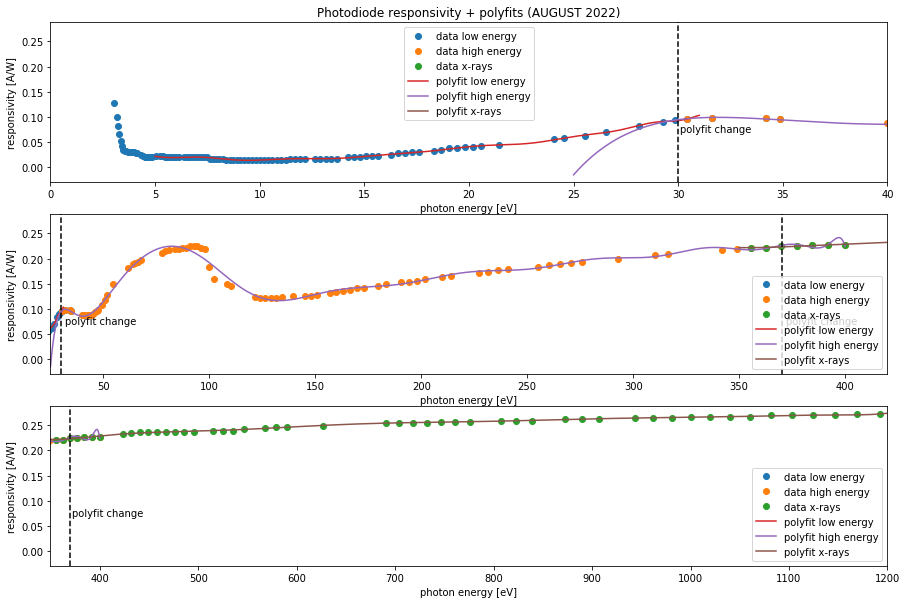

In [15]:
# load photodiode responsivity from a textfile:
lambda_nm, responsivity = [],[] #responsivity in Amperes per Watt!

filename = "sxuv_responsivity.txt"
startline = 3 #first two lines are useless

copy_lines=[]
with open(filename) as f:
    lines = f.readlines()

for line in lines:
    split_line = line.split()
    copy_lines.append(split_line)

    #from each line, extract a name/number and append it into its relevant column
for i in range(startline-1,len(copy_lines)-1):
    line = copy_lines[i]

    lambda_nm.append(float(line[0]))
    responsivity.append(float(line[1]))


pd_data = {'phot_E': convert_nm_to_eV(lambda_nm), 'wavelength': lambda_nm, 'responsivity' : responsivity}
responsivity_df_aug = pd.DataFrame(data=pd_data).sort_values('phot_E')

cond1 = responsivity_df_aug['phot_E'] <= 35
cond2 = responsivity_df_aug['phot_E'] > 3
cond3 = responsivity_df_aug['phot_E'] > 30
cond4 = responsivity_df_aug['phot_E'] <= 420
cond5 = responsivity_df_aug['phot_E'] > 350
cond6 = responsivity_df_aug['phot_E'] < 1200
energy_eV_aug_low = responsivity_df_aug[cond1 & cond2]['phot_E'].tolist()
energy_eV_aug_high = responsivity_df_aug[cond3 & cond4]['phot_E'].tolist()
energy_eV_aug_xray = responsivity_df_aug[cond5 & cond6]['phot_E'].tolist()
responsivity_aug_low = responsivity_df_aug[cond1 & cond2]['responsivity'].tolist()
responsivity_aug_high = responsivity_df_aug[cond3 & cond4]['responsivity'].tolist()
responsivity_aug_xray = responsivity_df_aug[cond5 & cond6]['responsivity'].tolist()

responsivity_fit_aug_low = np.poly1d(np.polyfit(energy_eV_aug_low, responsivity_aug_low, 25)) #make a polynomial fit for the first region
responsivity_fit_aug_high = np.poly1d(np.polyfit(energy_eV_aug_high, responsivity_aug_high, 20)) #make a polynomial fit for the first region
responsivity_fit_aug_xray = np.poly1d(np.polyfit(energy_eV_aug_xray, responsivity_aug_xray, 10)) #make a polynomial fit for the first region

test_eV_low = np.linspace(5,31,1000)
test_eV_high = np.linspace(25,400,10000)
test_eV_xray = np.linspace(350,1200,10000)

thresh_1_aug = 30 #photon energies (thresholds) at which polyfit needs to be changed
thresh_2_aug = 370

fig, (plt1, plt2, plt3) = plt.subplots(3, 1, figsize=(15,10))

plt1.set_xlabel('photon energy [eV]')
plt1.set_ylabel('responsivity [A/W]')
plt1.set_title('Photodiode responsivity + polyfits (AUGUST 2022)')
plt1.plot(energy_eV_aug_low,responsivity_aug_low,'o',label='data low energy')
plt1.plot(energy_eV_aug_high,responsivity_aug_high,'o',label='data high energy')
plt1.plot(energy_eV_aug_xray,responsivity_aug_xray,'o',label='data x-rays')
plt1.plot(test_eV_low, responsivity_fit_aug_low(test_eV_low), '-',label='polyfit low energy')
plt1.plot(test_eV_high, responsivity_fit_aug_high(test_eV_high), '-',label='polyfit high energy')
plt1.plot(test_eV_xray, responsivity_fit_aug_xray(test_eV_xray), '-',label='polyfit x-rays')
plt1.axvline(x=thresh_1_aug,linestyle='--',color='black')
plt1.text(s='polyfit change',x=thresh_1_aug+0.1,y=0.07)
plt1.legend()
plt1.set_xlim(0,40)

plt2.set_xlabel('photon energy [eV]')
plt2.set_ylabel('responsivity [A/W]')
plt2.plot(energy_eV_aug_low,responsivity_aug_low,'o',label='data low energy')
plt2.plot(energy_eV_aug_high,responsivity_aug_high,'o',label='data high energy')
plt2.plot(energy_eV_aug_xray,responsivity_aug_xray,'o',label='data x-rays')
plt2.plot(test_eV_low, responsivity_fit_aug_low(test_eV_low), '-',label='polyfit low energy')
plt2.plot(test_eV_high, responsivity_fit_aug_high(test_eV_high), '-',label='polyfit high energy')
plt2.plot(test_eV_xray, responsivity_fit_aug_xray(test_eV_xray), '-',label='polyfit x-rays')
plt2.axvline(x=thresh_1_aug,linestyle='--',color='black')
plt2.axvline(x=thresh_2_aug,linestyle='--',color='black')
plt2.text(s='polyfit change',x=thresh_1_aug+2,y=0.07)
plt2.text(s='polyfit change',x=thresh_2_aug+2,y=0.07)
plt2.legend()
plt2.set_xlim(25,420)

plt3.set_xlabel('photon energy [eV]')
plt3.set_ylabel('responsivity [A/W]')
plt3.plot(energy_eV_aug_low,responsivity_aug_low,'o',label='data low energy')
plt3.plot(energy_eV_aug_high,responsivity_aug_high,'o',label='data high energy')
plt3.plot(energy_eV_aug_xray,responsivity_aug_xray,'o',label='data x-rays')
plt3.plot(test_eV_low, responsivity_fit_aug_low(test_eV_low), '-',label='polyfit low energy')
plt3.plot(test_eV_high, responsivity_fit_aug_high(test_eV_high), '-',label='polyfit high energy')
plt3.plot(test_eV_xray, responsivity_fit_aug_xray(test_eV_xray), '-',label='polyfit x-rays')
plt3.axvline(x=thresh_1_aug,linestyle='--',color='black')
plt3.axvline(x=thresh_2_aug,linestyle='--',color='black')
plt3.text(s='polyfit change',x=thresh_2_aug+2,y=0.07)
plt3.legend()
plt3.set_xlim(350,1200)


# A function to compute the photoelectric yield:

In [16]:
def compute_yield(mat_df=object,PD_df=object,threshs_aug=list,threshs_march=list,pd_version=str,subtract_offset=bool):

    thresh_1_aug = threshs_aug[0]
    thresh_2_aug = threshs_aug[1]
    thresh_1_march = threshs_march[0]
    thresh_2_march = threshs_march[1]

    mat_phot_E = np.array(mat_df['phot_E'].tolist())
    PD_phot_E  = np.array(PD_df['phot_E'].tolist())

    if subtract_offset:
        mat_I = np.array(mat_df['I_KB_real'].tolist())
        PD_I  = np.array(PD_df[ 'I_KC_real'].tolist())

        mat_I_monit = np.array(mat_df['I_KA_real'].tolist())
        PD_I_monit  = np.array(PD_df[ 'I_KA_real'].tolist())
    else:
        mat_I = np.array(mat_df['I_KB'].tolist())
        PD_I  = np.array(PD_df[ 'I_KC'].tolist())

        mat_I_monit = np.array(mat_df['I_KA'].tolist())
        PD_I_monit  = np.array(PD_df[ 'I_KA'].tolist())

    print("material df: ",len(mat_phot_E),'\nphotodiode df:',len(PD_phot_E))


    length = min(len(mat_phot_E),len(PD_phot_E))

    #now I need to split the responsivity factor into two since I'm using two different polyfits of the photodiode responsivity
    R = []
    for i in range(length):
        if "march" in pd_version:
            if mat_phot_E[i] <= thresh_1_march:
                R.append(responsivity_fit_march_low(mat_phot_E[i]))
            elif (mat_phot_E[i] > thresh_1_march) and (mat_phot_E[i] < thresh_2_march):
                R.append(responsivity_fit_march_high(mat_phot_E[i]))
            elif mat_phot_E[i] >= thresh_1_march:
                R.append(responsivity_fit_march_xray(mat_phot_E[i]))
                

        elif "aug" in pd_version:
            if mat_phot_E[i] <= thresh_1_aug:
                R.append(responsivity_fit_aug_low(mat_phot_E[i]))
            elif (mat_phot_E[i] > thresh_1_aug) and (mat_phot_E[i] < thresh_2_aug):
                R.append(responsivity_fit_aug_high(mat_phot_E[i]))
            elif mat_phot_E[i] >= thresh_1_aug:
                R.append(responsivity_fit_aug_xray(mat_phot_E[i]))
        else:
            print("incorrect photodiode data")

    R = np.array(R)

    TEY = (mat_I[:length]/mat_I_monit[:length]) * (PD_I_monit[:length]/PD_I[:length]) * R[:length] * PD_phot_E[:length]
    
    TEY=list(TEY)
    while len(TEY) != len(mat_df):
        TEY.append(0)
    TEY=np.array(TEY)
    
    mat_df['Yield'] = 0
    mat_df['Yield'] = TEY
    return

# Photodiode LOW, COARSE (3-45 eV, 0.5eV step):

In [17]:
PD_low_file_number = 52 
PD_low_N_of_regs = 7
PD_low_reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
PD_low_add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
                    #KA        KB     KC
PD_low_sensvals = [['200pA','200pA','2uA'],
                   ['200pA','200pA','2uA'],
                   ['200pA','200pA','2uA'],
                   ['200pA','200pA','2uA'],
                   ['200pA','200pA','2uA'],
                   ['20nA','20nA','2uA'],
                   ['20nA','20nA','2uA']]

PD_low_df = concate_regions(file_number=PD_low_file_number,N_of_regs=PD_low_N_of_regs,material_name="PD_low",reject_regions=PD_low_reject_regs,add_regions_from_files=PD_low_add_regs_from_files)
subtract_offsets(PD_low_df,PD_low_sensvals,offsets_df)
PD_low_df.head()

,phot_E,I_KB,I_KA,I_KC,reg_number,material_name,phot_E_real,KA_offset,KB_offset,KC_offset,I_KA_real,I_KB_real,I_KC_real
0,3.499998,1.947000e-13,-4.300000e-15,2.200000e-10,1,PD_low,1.947000e-13,4.385542e-16,3.128313e-14,1.918485e-10,-4.738554e-15,1.634169e-13,2.815152e-11
1,3.999990,1.805000e-13,-5.300000e-15,2.180000e-10,1,PD_low,1.805000e-13,4.385542e-16,3.128313e-14,1.918485e-10,-5.738554e-15,1.492169e-13,2.615152e-11
2,4.499995,1.741000e-13,-2.700000e-15,2.290000e-10,2,PD_low,1.741000e-13,4.385542e-16,3.128313e-14,1.918485e-10,-3.138554e-15,1.428169e-13,3.715152e-11
3,4.999990,1.729000e-13,-5.700000e-15,2.820000e-10,2,PD_low,1.729000e-13,4.385542e-16,3.128313e-14,1.918485e-10,-6.138554e-15,1.416169e-13,9.015152e-11
4,5.499981,2.068000e-13,3.200000e-15,2.810000e-10,2,PD_low,2.068000e-13,4.385542e-16,3.128313e-14,1.918485e-10,2.761446e-15,1.755169e-13,8.915152e-11


Text(0, 0.5, 'diode current [A]')

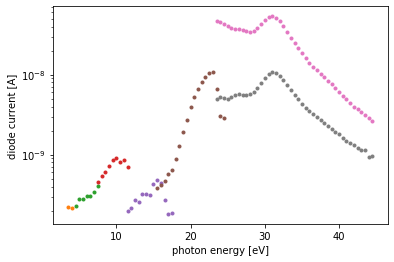

In [18]:
for i in range(8):
    criterion = PD_low_df['reg_number'] == i
    pd_df = PD_low_df.loc[criterion]
    
    plt.plot(pd_df['phot_E'],pd_df['I_KC'],'.')
plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('diode current [A]')

# Photodiode low, AUG 2021 

In [61]:
PD_compare_file_number = 14
PD_compare_N_of_regs = 7
PD_compare_reject_regs = [] 
PD_compare_add_regs_from_files = [0]

PD_compare_fine_df = concate_regions_old(file_number=PD_compare_file_number,N_of_regs=PD_compare_N_of_regs,material_name="PD_low_fine",reject_regions=PD_compare_reject_regs,add_regions_from_files=PD_compare_add_regs_from_files)

#offsets taken from August BEAR analysis
I_KB_offset_regs1to4 = 3.0037131578947363e-12
I_KA_offset_regs1to4 = 3.149824561403508e-14
I_KB_offset_reg5 = 2.441818181818182e-12
I_KA_offset_reg5 = 3.025454545454545e-14
I_KB_offset_regs6to7 = 3.3875000000000003e-12
I_KA_offset_regs6to7 = 3.9833333333333327e-13

df_copy = PD_compare_fine_df
df_copy['I_KA_offset'] = np.zeros(len(PD_compare_fine_df))
df_copy['I_KB_offset'] = np.zeros(len(PD_compare_fine_df))
df_copy['I_KC_offset'] = np.zeros(len(PD_compare_fine_df))
for i in range(len(PD_compare_fine_df)): #iterate over the rows of sample dataframe
    row = PD_compare_fine_df.iloc[[i]] #copy a single row
    reg_number = int(row['reg_number'].tolist()[0])

    if reg_number <= 4: 
        df_copy.at[i, 'I_KA_offset'] = I_KA_offset_regs1to4
        df_copy.at[i, 'I_KB_offset'] = I_KB_offset_regs1to4
        df_copy.at[i, 'I_KC_offset'] = I_KB_offset_regs1to4
    elif reg_number == 5 : 
        df_copy.at[i, 'I_KA_offset'] = I_KA_offset_reg5
        df_copy.at[i, 'I_KB_offset'] = I_KB_offset_reg5
        df_copy.at[i, 'I_KC_offset'] = I_KB_offset_reg5
    elif reg_number > 5 : 
        df_copy.at[i, 'I_KA_offset'] = I_KA_offset_regs6to7
        df_copy.at[i, 'I_KB_offset'] = I_KB_offset_regs6to7
        df_copy.at[i, 'I_KC_offset'] = I_KB_offset_regs6to7
    else: print("didn't find offset from august!")
PD_compare_fine_df = df_copy

PD_compare_fine_df['I_KC'] = PD_compare_fine_df['I_KB']
PD_compare_fine_df['I_KA_real'] = PD_compare_fine_df['I_KA'] - PD_compare_fine_df['I_KA_offset']
PD_compare_fine_df['I_KB_real'] = PD_compare_fine_df['I_KB'] - PD_compare_fine_df['I_KB_offset'] 
PD_compare_fine_df['I_KC_real'] = PD_compare_fine_df['I_KC'] - PD_compare_fine_df['I_KC_offset'] 

#PD_compare_fine_df = PD_compare_fine_df.loc[PD_compare_fine_df['reg_number'] != 7] #delete 7th region

def pick_rows(df=object, tolerance=float, around_energies=list): #a function to only pick rows corresponding to 0.5 eV steps:
    temp_df = df.iloc[[0]]
    for i in range(1,len(df)): #iterate over the rows of sample dataframe
            row = df.iloc[[i]] #copy a single row
            for val in around_energies:
                if abs(val-float(row['phot_E'])) < tolerance:
                    temp_df = pd.concat([temp_df,row])
    return  temp_df

#creating a dataframe for august photodiode data, making, picking rows with 0.5 eV step
#PD_compare_coarse_df = PD_compare_fine_df.loc[PD_compare_fine_df['reg_number'] != 7] #delete the last region, it appears twice
PD_compare_coarse_df = pick_rows(df=PD_compare_fine_df,tolerance=0.05,around_energies=np.arange(3,30.5,0.5))


# Photodiode LOW, FINE (3-45 eV, 0.1 step)

In [20]:
PD_low_fine_file_number = 53
PD_low_fine_N_of_regs = 7
PD_low_fine_reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
PD_low_fine_add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
                          #KA      KB     KC
PD_low_fine_sensvals = [['200pA','200pA','2uA'],
                        ['200pA','200pA','2uA'],
                        ['200pA','200pA','2uA'],
                        ['200pA','200pA','2uA'],
                        ['200pA','200pA','2uA'],
                        ['20nA','20nA','2uA'],
                        ['20nA','20nA','2uA']]

PD_low_fine_df = concate_regions(file_number=PD_low_fine_file_number,N_of_regs=PD_low_fine_N_of_regs,material_name="PD_low_fine",reject_regions=PD_low_fine_reject_regs,add_regions_from_files=PD_low_fine_add_regs_from_files)
subtract_offsets(PD_low_fine_df,PD_low_fine_sensvals,offsets_df)
#PD_low_fine_df = PD_low_fine_df.loc[PD_low_fine_df['reg_number'] != 7]
PD_low_fine_df.head()

,phot_E,I_KB,I_KA,I_KC,reg_number,material_name,phot_E_real,KA_offset,KB_offset,KC_offset,I_KA_real,I_KB_real,I_KC_real
0,3.099994,1.232000e-13,-1.600000e-15,2.180000e-10,1,PD_low_fine,1.232000e-13,4.385542e-16,3.128313e-14,1.918485e-10,-2.038554e-15,9.191687e-14,2.615152e-11
1,3.199996,1.792000e-13,-6.800000e-15,2.230000e-10,1,PD_low_fine,1.792000e-13,4.385542e-16,3.128313e-14,1.918485e-10,-7.238554e-15,1.479169e-13,3.115152e-11
2,3.300000,1.622000e-13,-8.700000e-15,2.460000e-10,1,PD_low_fine,1.622000e-13,4.385542e-16,3.128313e-14,1.918485e-10,-9.138554e-15,1.309169e-13,5.415152e-11
3,3.399999,2.123000e-13,-2.300000e-15,2.190000e-10,1,PD_low_fine,2.123000e-13,4.385542e-16,3.128313e-14,1.918485e-10,-2.738554e-15,1.810169e-13,2.715152e-11
4,3.500002,2.148000e-13,-2.900000e-15,2.410000e-10,1,PD_low_fine,2.148000e-13,4.385542e-16,3.128313e-14,1.918485e-10,-3.338554e-15,1.835169e-13,4.915152e-11


# Comparison of August and March photodiode currents (accounting for different responsivities)

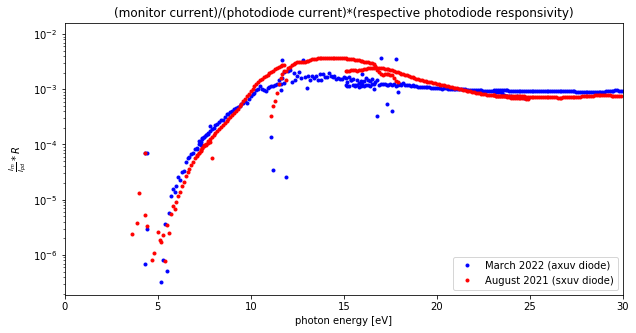

In [21]:
figure(figsize=(10, 5))

for i in range(7):
    criterion = PD_low_fine_df['reg_number'] == i
    pd_df_march = PD_low_fine_df.loc[criterion]
    ph_E = np.array(pd_df_march['phot_E'].tolist())
    I_KC = np.array(pd_df_march['I_KC_real'].tolist())
    I_KA = np.array(pd_df_march['I_KA_real'].tolist())
    if i==1:
        plt.plot(ph_E,I_KA/I_KC*responsivity_fit_march_low(ph_E),'.',color='blue',label='March 2022 (axuv diode)')
    else:    
        plt.plot(ph_E,I_KA/I_KC*responsivity_fit_march_low(ph_E),'.',color='blue')

for i in range(7):
    criterion = PD_compare_fine_df['reg_number'] == i
    pd_df_aug = PD_compare_fine_df.loc[criterion]
    ph_E = np.array(pd_df_aug['phot_E'].tolist())
    I_KB = np.array(pd_df_aug['I_KB_real'].tolist()) #back in August, we measured photodiode current on KB, not KC
    I_KA = np.array(pd_df_aug['I_KA_real'].tolist())
    if i ==1: 
        plt.plot(ph_E,I_KA/I_KB*responsivity_fit_aug_low(ph_E),'.',color='red',label='August 2021 (sxuv diode)')
    else:
        plt.plot(ph_E,I_KA/I_KB*responsivity_fit_aug_low(ph_E),'.',color='red')


plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.title('(monitor current)/(photodiode current)*(respective photodiode responsivity)')
plt.ylabel(r'$\frac{I_{m}}{I_{pd}} * R$')
plt.xlim(0,30)
#plt.ylim(0,0.004)
plt.legend(loc='lower right')
#plt.savefig('plots/photodiode_comparisons.png', dpi=300)

# Photodiode HIGH (40-1500 eV):

Text(0, 0.5, 'diode current [A]')

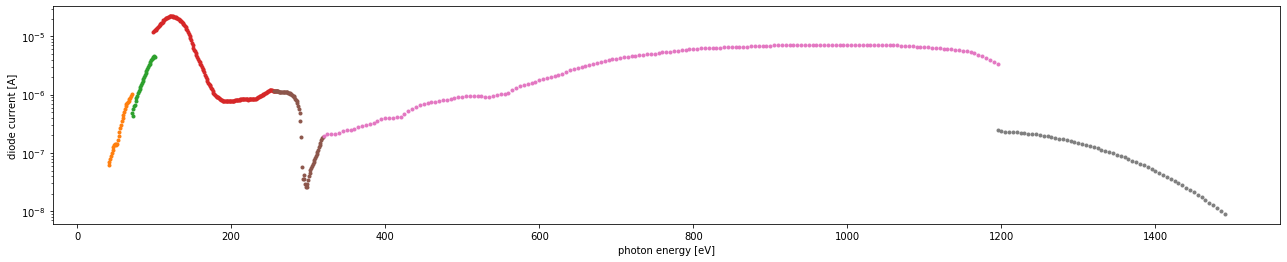

In [22]:
PD_high_file_number = 47
PD_high_N_of_regs = 7
PD_high_reject_regs = [4,7] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
PD_high_add_regs_from_files = [0,48] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
PD_high_sensvals = [['2uA','20nA','2uA'],
                    ['20nA','20nA','20uA'],
                    ['200nA','20nA','200uA'],
                    ['20nA','200pA','2uA'],
                    ['20nA','200pA','2uA'],
                    ['200nA','20nA','20uA'],
                    ['20nA','200pA','2uA']]

PD_high_df = concate_regions(file_number=PD_high_file_number,N_of_regs=PD_high_N_of_regs,material_name='PD_high',reject_regions=PD_high_reject_regs,add_regions_from_files=PD_high_add_regs_from_files)
subtract_offsets(PD_high_df,PD_high_sensvals,offsets_df)

figure(figsize=(22, 4))
for i in range(12):
    criterion = PD_high_df['reg_number'] == i
    pd_df = PD_high_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KC_real'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('diode current [A]')

# Gold LOW (3-45eV):

Text(0.5, 1.0, 'Gold current: March 2022')

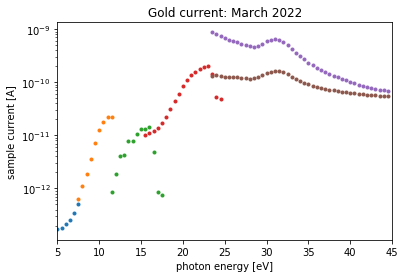

In [23]:
mat_name = 'Gold_low'
mat_file_number = 12
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
Gold_low_sensvals =[['200pA','200pA','200pA'],
                    ['200pA','200pA','200pA'],
                    ['200pA','200pA','200pA'],
                    ['200pA','200pA','200pA'],
                    ['200pA','200pA','200pA'],
                    ['20nA','20nA','200pA'],
                    ['20nA','20nA','200pA']]

Gold_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(Gold_low_df,Gold_low_sensvals,offsets_df)

for i in range(2,8):
    criterion = Gold_low_df['reg_number'] == i
    pd_df = Gold_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB_real'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')
plt.xlim(5,45)
plt.title('Gold current: March 2022')
#plt.savefig('plots/Au_current_March.png', dpi=300)

material df:  136 
photodiode df: 136


(0, 30)

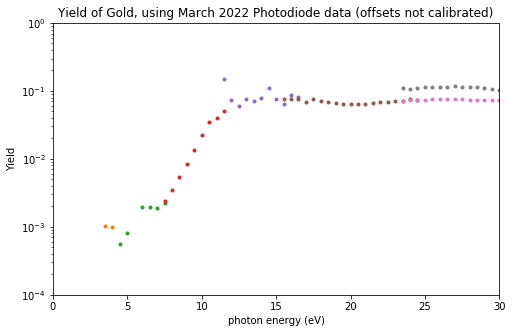

In [24]:
compute_yield(mat_df=Gold_low_df,PD_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)

figure(figsize=(8, 5))
for i in range(8):
    criterion = Gold_low_df['reg_number'] == i
    pd_df = Gold_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.ylim(1e-4,1)
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')
plt.title('Yield of Gold, using March 2022 Photodiode data (offsets not calibrated)')
plt.savefig('plots/Au_test_march22_PD.png', dpi=300)
plt.xlim(0,30)


In [25]:
def read_text_file(filename):
    photon_E, total_yield, yield_error = [],[],[]
    
    copy_lines=[]
    with open(filename) as f:
        lines = f.readlines()

    for line in lines:
        split_line = line.split()
        copy_lines.append(split_line)

    #from each line, extract a name/number and append it into its relevant column
    for i in range(1,len(copy_lines)-1): #2nd line in the file is the first relevant one
        line = copy_lines[i]

        photon_E.append(float(line[0])) #strip element name and type of commas
        total_yield.append(float(line[1]))
        yield_error.append(float(line[2]))

    return([photon_E, total_yield, yield_error])

# Gold Low, Coarse, March 2022 Sample data, Aug 2021 photodiode data

material df:  77 
photodiode df: 77
material df:  136 
photodiode df: 136


/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


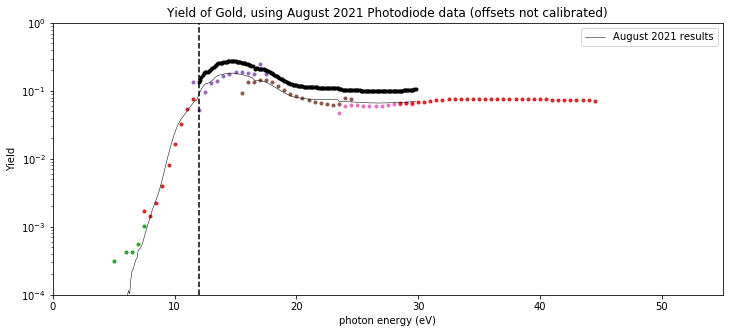

In [26]:
mat_name = 'Gold_low'
mat_file_number = 12
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
Gold_low_sensvals =[['200pA','200pA','200pA'],
                    ['200pA','200pA','200pA'],
                    ['200pA','200pA','200pA'],
                    ['200pA','200pA','200pA'],
                    ['200pA','200pA','200pA'],
                    ['20nA','20nA','200pA'],
                    ['20nA','20nA','200pA']]

Gold_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
Gold_low2_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(Gold_low_df,Gold_low_sensvals,offsets_df)
subtract_offsets(Gold_low2_df,Gold_low_sensvals,offsets_df)

sub30_gold_df = Gold_low_df.loc[Gold_low_df['phot_E'] < 30]
compute_yield(mat_df=sub30_gold_df,PD_df=PD_compare_coarse_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=True)
compute_yield(mat_df=Gold_low2_df,PD_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=False)

figure(figsize=(12, 5))

for i in range(7):
    criterion = sub30_gold_df['reg_number'] == i
    pd_df = sub30_gold_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
for i in range(7):
    criterion = (Gold_low2_df['reg_number'] == i) & (Gold_low2_df['phot_E'] > 28) 
    pd_df = Gold_low2_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.ylim(1e-4,1)
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')
plt.title('Yield of Gold, using August 2021 Photodiode data (offsets not calibrated)')
plt.savefig('plots/Au_test_aug21_PD.png', dpi=300)
plt.xlim(0,55)

[Au_45_E, Au_45_TEY, Au_45_TEY_err] = read_text_file('TEY_files/Au_45deg.txt')
plt.axvline(x=12,color='black',linestyle='--')
for i in range(len(Au_45_E)):
    if Au_45_E[i]>=12:
        plt.plot(Au_45_E[i],Au_45_TEY[i]*1.5,'.',color='black')
plt.plot(Au_45_E,np.array(Au_45_TEY),color="black",linewidth=0.5,label="August 2021 results")

plt.legend()

# Gold HIGH (40-1500 eV)

material df:  524 
photodiode df: 523


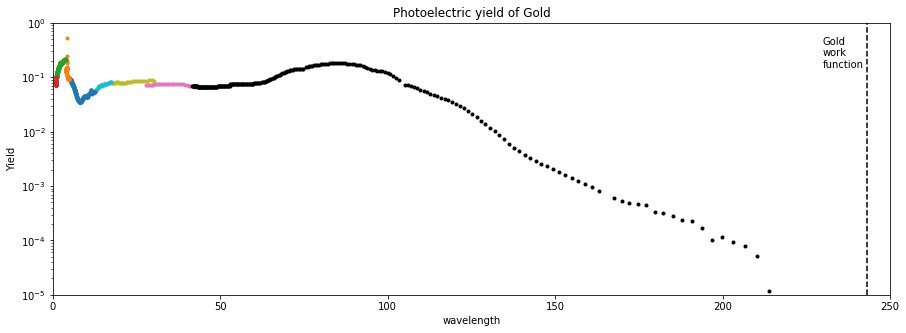

In [38]:
mat_name = 'Gold_high'
mat_file_number = 10
mat_N_of_regs = 6
reject_regs = [5,6] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves! (in order!)
add_regs_from_files = [11,11] #number of files from which each respective saturated region shall be substituted from (set 0 if it's supposed to stay empty)
Gold_high_sensvals=[['20nA','20nA','200nA'],
                    ['20nA','20nA','200nA'],
                    ['200nA','20nA','200nA'],
                    ['200pA','200pA','200nA'],
                    ['20nA','20nA','200nA'],
                    ['200pA','200pA','200nA']]


Gold_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(Gold_high_df,Gold_high_sensvals,offsets_df)
compute_yield(mat_df=Gold_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
figure(figsize=(15, 5))
for i in range(7):
    criterion = (Gold_low2_df['reg_number'] == i) & (Gold_low2_df['phot_E'] > 28) 
    pd_df = Gold_low2_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = Gold_high_df['reg_number'] == i
    pd_df = Gold_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')

plt.plot(convert_eV_to_nm(np.array(Au_45_E)),np.array(Au_45_TEY),'.',color="black",label="August 2021 results")
plt.axvline(x=convert_eV_to_nm([5.1])[0],color='black',linestyle='--')
plt.text(s='Gold\nwork\nfunction',x=230,y=0.15)
plt.yscale('log')
plt.xlim(0,250)
plt.ylim(1e-5,1)
plt.ylabel("Yield")
plt.xlabel('wavelength')
plt.title('Photoelectric yield of Gold')
plt.savefig('plots/Au_full_yield.png', dpi=300)


# Mg Alloy LOW (fine, 3-45 eV, 0.1eV step)

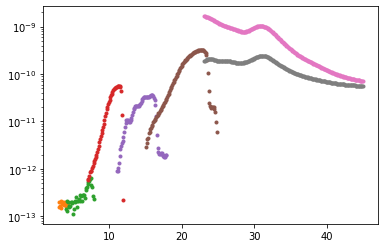

In [28]:
mat_name = 'Mg_alloy_low'
mat_file_number = 24
mat_N_of_regs = 7
reject_regs = [5] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [26] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
Mg_alloy_low_sensvals =[['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['20nA','20nA','200pA'],
                        ['20nA','20nA','200pA']]

Mg_alloy_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(Mg_alloy_low_df,Mg_alloy_low_sensvals,offsets_df)

Mg_alloy_low_df_aug = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
Mg_alloy_low_df_aug = Mg_alloy_low_df_aug.loc[Mg_alloy_low_df_aug['phot_E'] < 31]
subtract_offsets(Mg_alloy_low_df_aug,Mg_alloy_low_sensvals,offsets_df)

for i in range(8):
    criterion = Mg_alloy_low_df['reg_number'] == i
    pd_df = Mg_alloy_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB_real'],'.')
plt.yscale('log')

# Mg alloy, using AUG 2021 photodiode

material df:  707 
photodiode df: 708
material df:  506 
photodiode df: 408


(0.0001, 1)

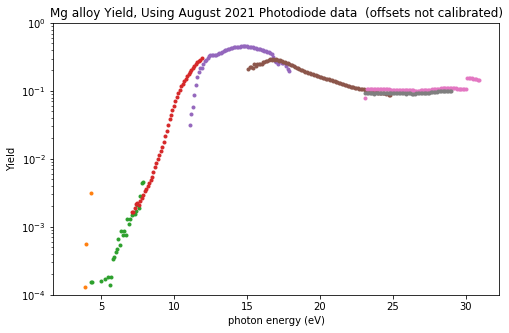

In [39]:
compute_yield(mat_df=Mg_alloy_low_df,PD_df=PD_low_fine_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=False)
compute_yield(mat_df=Mg_alloy_low_df_aug,PD_df=PD_compare_fine_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=True)

figure(figsize=(8, 5))
for i in range(8):
    criterion = Mg_alloy_low_df_aug['reg_number'] == i
    pd_df = Mg_alloy_low_df_aug.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
#for i in range(8):
#    criterion = Mg_alloy_low_df['reg_number'] == i
#    pd_df = Mg_alloy_low_df.loc[criterion]
#    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')

plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')
plt.title('Mg alloy Yield, Using August 2021 Photodiode data  (offsets not calibrated)')
plt.ylim(1e-4,1)
#plt.savefig('plots/Mg_alloy_test_Aug21_PD.png', dpi=300)

# Mg Alloy HIGH (40-1500 eV, 0.5eV step)

material df:  524 
photodiode df: 523


Text(0.5, 1.0, 'Mg Alloy Yield')

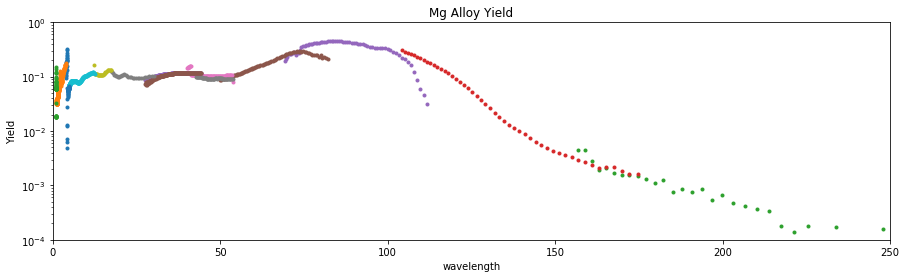

In [42]:
mat_name = 'Mg_alloy_high'
mat_file_number = 19
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
Mg_alloy_high_sensvals =[['20nA','20nA','200nA'],
                         ['20nA','20nA','200nA'],
                         ['200nA','20nA','200nA'],
                         ['200pA','200pA','200nA'],
                         ['20nA','20nA','200nA'],
                         ['200pA','200pA','200pA']]

Mg_alloy_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(Mg_alloy_high_df,Mg_alloy_high_sensvals,offsets_df)

compute_yield(mat_df=Mg_alloy_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)
phot_E = np.array(PD_high_df['phot_E'].tolist())

figure(figsize=(15, 4))

for i in range(8):
    criterion = Mg_alloy_low_df_aug['reg_number'] == i
    pd_df = Mg_alloy_low_df_aug.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = (Mg_alloy_low_df['reg_number'] == i) & (Mg_alloy_low_df['phot_E'] >= 28)
    pd_df = Mg_alloy_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = Mg_alloy_high_df['reg_number'] == i
    pd_df = Mg_alloy_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')

plt.yscale('log')
plt.xlim(0,250)
plt.ylim(1e-4,1)
plt.xlabel('wavelength')
plt.ylabel('Yield')
plt.title('Mg Alloy Yield')

# ITO Radiator, LOW 

material df:  78 
photodiode df: 77
material df:  136 
photodiode df: 136


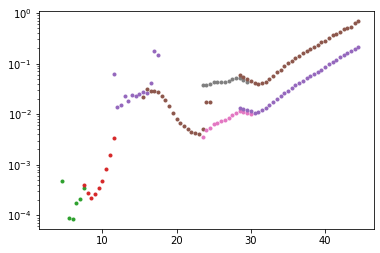

In [60]:
mat_name = 'ITO_radiator_low'
mat_file_number = 22
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
ITO_radiator_low_sensvals =[['200pA','200pA','200pA'],
                            ['200pA','200pA','200pA'],
                            ['200pA','200pA','200pA'],
                            ['200pA','200pA','200pA'],
                            ['200pA','200pA','200pA'],
                            ['20nA','20nA','200pA'],
                            ['20nA','20nA','200pA']]


ITO_radiator_low_df_aug = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_radiator_low_df_aug,ITO_radiator_low_sensvals,offsets_df)
ITO_radiator_low_df_aug = ITO_radiator_low_df_aug.loc[ITO_radiator_low_df_aug['phot_E'] < 30]

ITO_radiator_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_radiator_low_df,ITO_radiator_low_sensvals,offsets_df)

compute_yield(mat_df=ITO_radiator_low_df_aug,PD_df=PD_compare_coarse_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=True)
compute_yield(mat_df=ITO_radiator_low_df,PD_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)

for i in range(8):
    criterion = ITO_radiator_low_df_aug['reg_number'] == i
    pd_df = ITO_radiator_low_df_aug.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
for i in range(8):
    criterion = (ITO_radiator_low_df['reg_number'] == i) & (ITO_radiator_low_df['phot_E'] > 28)
    pd_df = ITO_radiator_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')

# ITO Radiator High

material df:  524 
photodiode df: 523


Text(0.5, 1.0, 'ITO radiator yield')

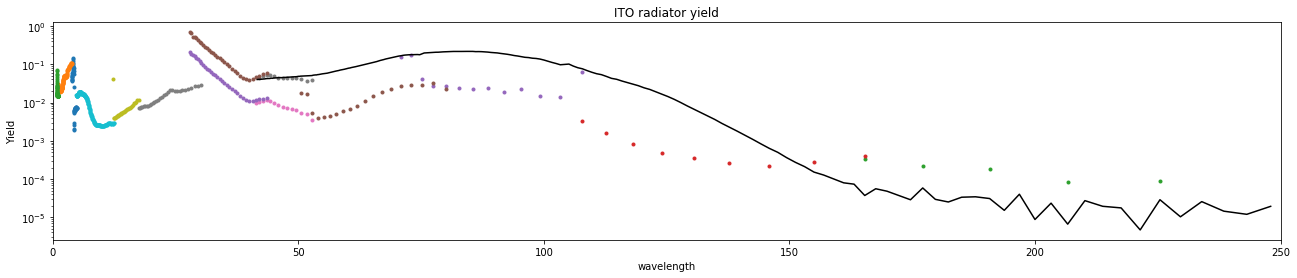

In [56]:
mat_name = 'ITO_radiator_high'
mat_file_number = 21
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
ITO_radiator_high_sensvals =[['20nA','20nA','200nA'],
                            ['20nA','20nA','200nA'],
                            ['200nA','20nA','200nA'],
                            ['200pA','200pA','200nA'],
                            ['20nA','20nA','200nA'],
                            ['200pA','200pA','200nA']]

ITO_radiator_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_radiator_high_df,ITO_radiator_high_sensvals,offsets_df)

compute_yield(mat_df=ITO_radiator_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march',subtract_offset=True)

figure(figsize=(22, 4))

for i in range(8):
    criterion = ITO_radiator_low_df_aug['reg_number'] == i
    pd_df = ITO_radiator_low_df_aug.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = (ITO_radiator_low_df['reg_number'] == i) & (ITO_radiator_low_df['phot_E'] > 28)
    pd_df = ITO_radiator_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = ITO_radiator_high_df['reg_number'] == i
    pd_df = ITO_radiator_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')

[ITO_Radiator_1_45_E, ITO_Radiator_1_45_TEY, ITO_Radiator_1_45_TEY_err] = read_text_file('TEY_files/ITO_Radiator_1_45deg.txt')
plt.plot(convert_eV_to_nm(ITO_Radiator_1_45_E),ITO_Radiator_1_45_TEY,color='black')

plt.yscale('log')
plt.xlim(0,250)
plt.xlabel('wavelength')
plt.ylabel('Yield')
plt.title('ITO radiator yield')

# ITO MLI Low

In [69]:
mat_name = 'ITO_MLI'
mat_file_number = 23
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
ITO_MLI_low_sensvals = [['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['20nA','20nA','200pA'],
                        ['20nA','20nA','200pA']]

ITO_MLI_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_MLI_low_df,ITO_MLI_low_sensvals,offsets_df)
ITO_MLI2_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_MLI2_low_df,ITO_MLI_low_sensvals,offsets_df)

ITO_MLI_low_df = ITO_MLI_low_df.loc[ITO_MLI_low_df['phot_E'] < 30]

compute_yield(mat_df=ITO_MLI_low_df,PD_df=PD_compare_coarse_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=True)
compute_yield(mat_df=ITO_MLI2_low_df,PD_df=PD_low_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=True)



material df:  77 
photodiode df: 77
material df:  136 
photodiode df: 136


# ITO MLI High

material df:  524 
photodiode df: 523


Text(0.5, 1.0, 'ITO MLI yield')

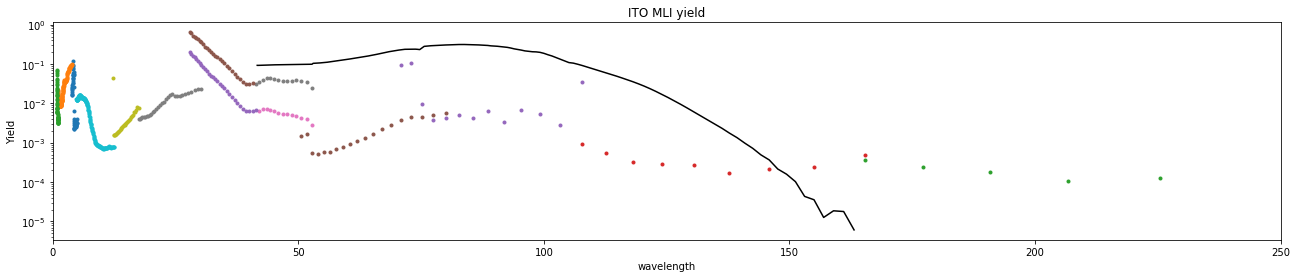

In [73]:
mat_name = 'ITO_radiator_high'
mat_file_number = 20
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
ITO_MLI_high_sensvals =[['20nA','20nA','200nA'],
                        ['20nA','20nA','200nA'],
                        ['200nA','20nA','200nA'],
                        ['200pA','200pA','200nA'],
                        ['20nA','20nA','200nA'],
                        ['200pA','200pA','200nA']]

ITO_MLI_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_MLI_high_df,ITO_MLI_high_sensvals,offsets_df)
compute_yield(mat_df=ITO_MLI_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version='march',subtract_offset=True)
figure(figsize=(22, 4))

for i in range(8):
    criterion = ITO_MLI_low_df['reg_number'] == i
    pd_df = ITO_MLI_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = (ITO_MLI2_low_df['reg_number'] == i) & (ITO_MLI2_low_df['phot_E'] >=30)
    pd_df = ITO_MLI2_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = ITO_MLI_high_df['reg_number'] == i
    pd_df = ITO_MLI_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')

[ITO_MLI_1_45_E, ITO_MLI_1_45_TEY, ITO_MLI_1_45_TEY_err] = read_text_file('TEY_files/ITO_MLI_1_45deg.txt')
plt.plot(convert_eV_to_nm(ITO_MLI_1_45_E),ITO_MLI_1_45_TEY,color='black')

plt.yscale('log')
plt.xlim(0,250)
plt.xlabel('wavelength')
plt.ylabel('Yield')
plt.title('ITO MLI yield')


# Aerodag LOW

material df:  74 
photodiode df: 77


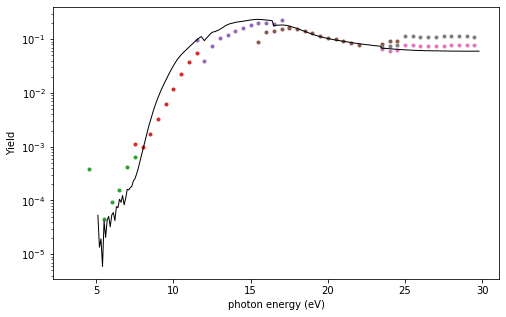

In [87]:
mat_name = 'Aerodag_low'
mat_file_number = 32
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
aerodag_low_sensvals = [['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['200pA','200pA','200pA'],
                        ['20nA','20nA','200pA'],
                        ['20nA','20nA','200pA']]


aerodag_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(aerodag_low_df,aerodag_low_sensvals,offsets_df)
aerodag_low_df = aerodag_low_df.drop(aerodag_low_df[aerodag_low_df.I_KB > 1e5].index) #delete outliers in current
aerodag_low_df = aerodag_low_df.loc[aerodag_low_df['phot_E'] <= 30 ]
compute_yield(mat_df=aerodag_low_df,PD_df=PD_compare_coarse_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=True)

figure(figsize=(8, 5))
for i in range(8):
    criterion = aerodag_low_df['reg_number'] == i
    pd_df = aerodag_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')

[Aerodag_SS_45_E, Aerodag_SS_45_TEY, Aerodag_SS_45_TEY_err] = read_text_file('TEY_files/Aerodag_SS_45deg.txt')
plt.plot(Aerodag_SS_45_E,Aerodag_SS_45_TEY,color='black',linewidth=1)

# Aerodag HIGH

material df:  524 
photodiode df: 523


Text(0.5, 1.0, 'Aerodag Yield')

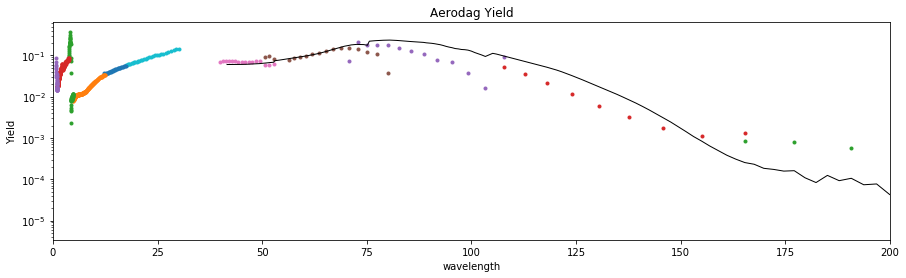

In [ ]:
mat_name = 'Aerodag_high'
mat_file_number = 27
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)
aerodag_high_sensvals =[['20nA','20nA','200nA'],
                        ['20nA','20nA','200nA'],
                        ['200nA','20nA','200nA'],
                        ['200pA','200pA','200nA'],
                        ['20nA','20nA','200nA'],
                        ['200pA','200pA','200nA']]

aerodag_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(aerodag_high_df,aerodag_high_sensvals,offsets_df)

compute_yield(mat_df=aerodag_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=False)

figure(figsize=(15, 4))

for i in range(8):
    criterion = aerodag_low_df['reg_number'] == i
    pd_df = aerodag_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = aerodag_high_df['reg_number'] == i
    pd_df = aerodag_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')

plt.plot(convert_eV_to_nm(Aerodag_SS_45_E),Aerodag_SS_45_TEY,color='black',linewidth=1)

plt.yscale('log')
plt.xlim(0,200)
plt.xlabel('wavelength')
plt.ylabel('Yield')
plt.title('Aerodag Yield')

# Graphite

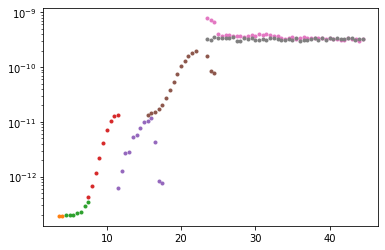

In [ ]:
mat_name = 'Graphite'
mat_file_number = 13
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

graphite_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
graphite_low_df = graphite_low_df.drop(graphite_low_df[graphite_low_df.I_KB > 1e5].index) #delete outliers in current:
subtract_offsets(graphite_low_df,offsets_df)

for i in range(8):
    criterion = graphite_low_df['reg_number'] == i
    pd_df = graphite_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB'],'.')
plt.yscale('log')

material df:  134 
photodiode df: 64


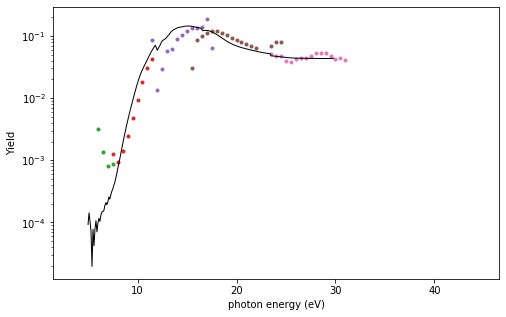

In [ ]:
compute_yield(mat_df=graphite_low_df,PD_df=PD_compare_coarse_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=False)

figure(figsize=(8, 5))
for i in range(8):
    criterion = graphite_low_df['reg_number'] == i
    pd_df = graphite_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')

[Graphite_SS_45_E, Graphite_SS_45_TEY, Graphite_SS_45_TEY_err] = read_text_file('TEY_files/Graphite_SS_45deg.txt')
plt.plot(Graphite_SS_45_E,Graphite_SS_45_TEY,color='black',linewidth=1)

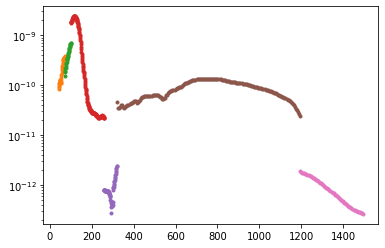

In [ ]:
mat_name = 'Graphite_high'
mat_file_number = 9
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

graphite_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
graphite_high_df = graphite_high_df.drop(graphite_high_df[graphite_high_df.I_KB > 1e5].index) #delete outliers in current:
subtract_offsets(graphite_high_df,offsets_df)

for i in range(8):
    criterion = graphite_high_df['reg_number'] == i
    pd_df = graphite_high_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB'],'.')
plt.yscale('log')

material df:  524 
photodiode df: 523


Text(0.5, 1.0, 'Graphite on Stainless Steel')

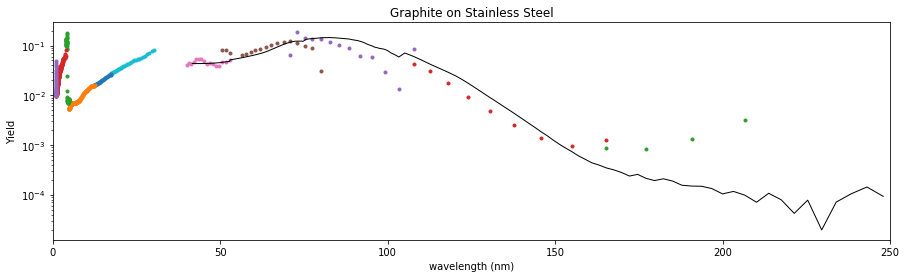

In [ ]:
compute_yield(mat_df=graphite_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=False)

figure(figsize=(15, 4))
for i in range(8):
    criterion = graphite_low_df['reg_number'] == i
    pd_df = graphite_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = graphite_high_df['reg_number'] == i
    pd_df = graphite_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
plt.plot(convert_eV_to_nm(Graphite_SS_45_E),Graphite_SS_45_TEY,color='black',linewidth=1)
plt.yscale('log')
plt.xlabel('wavelength (nm)')
plt.ylabel('Yield')
plt.xlim(0,250)
plt.title('Graphite on Stainless Steel')

# Coverglass Low

Text(0, 0.5, 'sample current [A]')

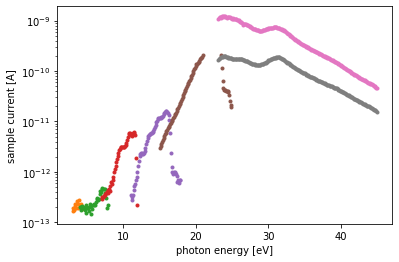

In [ ]:
mat_name = 'Coverglass'
mat_file_number = 30
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

coverglass_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
coverglass_low_df = coverglass_low_df.drop(coverglass_low_df[coverglass_low_df.I_KB > 1e5].index) #delete outliers in current:
subtract_offsets(coverglass_low_df,offsets_df)

for i in range(8):
    criterion = coverglass_low_df['reg_number'] == i
    pd_df = coverglass_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')

material df:  684 
photodiode df: 339


Text(0, 0.5, 'Yield')

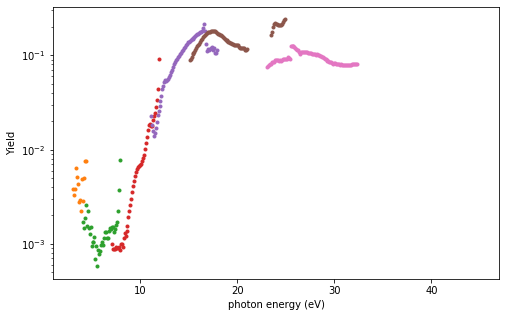

In [ ]:
compute_yield(mat_df=coverglass_low_df,PD_df=PD_compare_fine_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=False)

figure(figsize=(8, 5))
for i in range(8):
    criterion = coverglass_low_df['reg_number'] == i
    pd_df = coverglass_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')

# Coverglass High

Text(0, 0.5, 'sample current [A]')

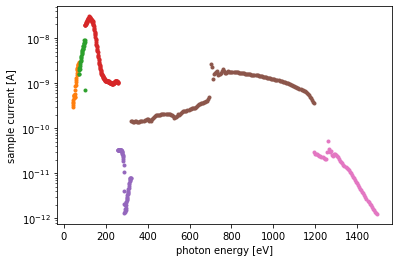

In [ ]:
mat_name = 'Coverglass_high'
mat_file_number = 29
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

coverglass_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(coverglass_high_df,offsets_df)

for i in range(8):
    criterion = coverglass_high_df['reg_number'] == i
    pd_df = coverglass_high_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')

material df:  524 
photodiode df: 523


Text(0.5, 1.0, 'Coverglass')

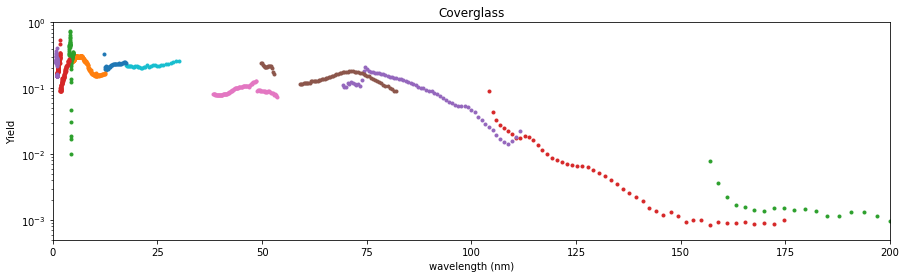

In [ ]:
compute_yield(mat_df=coverglass_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=False)

figure(figsize=(15, 4))
for i in range(8):
    criterion = coverglass_low_df['reg_number'] == i
    pd_df = coverglass_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = coverglass_high_df['reg_number'] == i
    pd_df = coverglass_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')

plt.yscale('log')
plt.xlabel('wavelength (nm)')
plt.ylabel('Yield')
plt.xlim(0,200)
plt.ylim(0.5e-3,1)
plt.title('Coverglass')

# LHS Low

Text(0, 0.5, 'electron count (electron analyzer)')

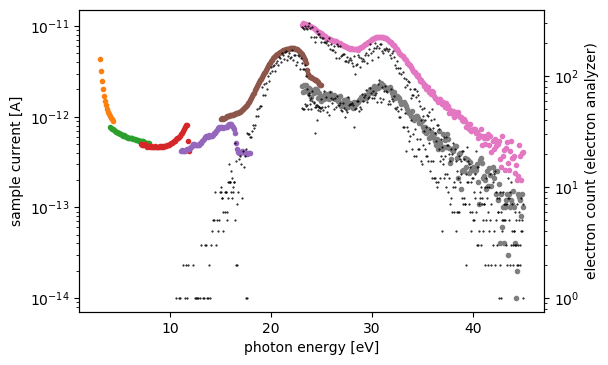

In [ ]:
mat_name = 'LHS_low'
mat_file_number = 81
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

LHS_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(LHS_low_df,offsets_df)

fig, ax1 = plt.subplots(figsize=(6,4), dpi=100)
ax2 = ax1.twinx()

for i in range(8):
    criterion = LHS_low_df['reg_number'] == i
    pd_df = LHS_low_df.loc[criterion]
    ax1.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

for i in range(8):
    criterion = LHS_low_df['reg_number'] == i
    pd_df = LHS_low_df.loc[criterion]
    ax2.plot(pd_df['phot_E'],pd_df['I_KC'],'.',color="black",markersize=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('photon energy [eV]')
ax1.set_ylabel('sample current [A]')
ax2.set_ylabel('electron count (electron analyzer)')

material df:  708 
photodiode df: 339


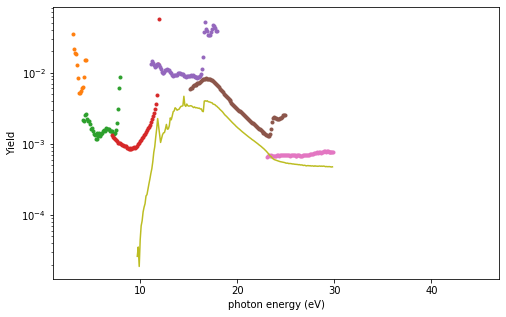

In [ ]:
compute_yield(mat_df=LHS_low_df,PD_df=PD_compare_fine_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=False)

figure(figsize=(8, 5))
for i in range(8):
    criterion = LHS_low_df['reg_number'] == i
    pd_df = LHS_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')

[fake_dust_45_E, fake_dust_45_TEY, fake_dust_45_TEY_err] = read_text_file('TEY_files/fake_dust_45deg.txt')
plt.plot(fake_dust_45_E,fake_dust_45_TEY)

# LHS High

Text(0, 0.5, 'electron count (electron analyzer)')

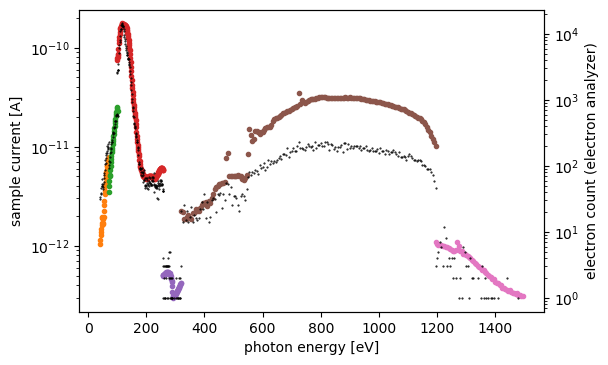

In [ ]:
mat_name = 'LHS_high'
mat_file_number = 79
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

LHS_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(LHS_high_df,offsets_df)

fig, ax1 = plt.subplots(figsize=(6,4), dpi=100)
ax2 = ax1.twinx()

for i in range(8):
    criterion = LHS_high_df['reg_number'] == i
    pd_df = LHS_high_df.loc[criterion]
    ax1.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

for i in range(8):
    criterion = LHS_high_df['reg_number'] == i
    pd_df = LHS_high_df.loc[criterion]
    ax2.plot(pd_df['phot_E'],pd_df['I_KC'],'.',color="black",markersize=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('photon energy [eV]')
ax1.set_ylabel('sample current [A]')
ax2.set_ylabel('electron count (electron analyzer)')

material df:  524 
photodiode df: 523


(0, 250)

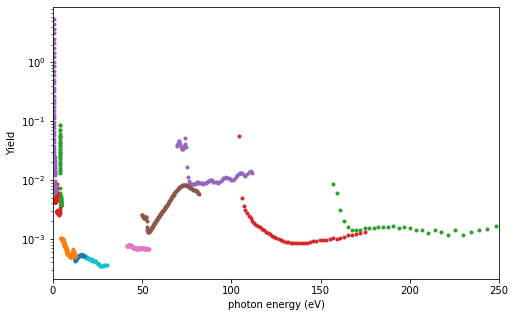

In [ ]:
compute_yield(mat_df=LHS_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=False)

figure(figsize=(8, 5))
for i in range(8):
    criterion = LHS_low_df['reg_number'] == i
    pd_df = LHS_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = LHS_high_df['reg_number'] == i
    pd_df = LHS_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')
plt.xlim(0,250)


# LM Thin 1 Low (Lunar Meteorite, Position 1)

Text(0, 0.5, 'electron count (electron analyzer)')

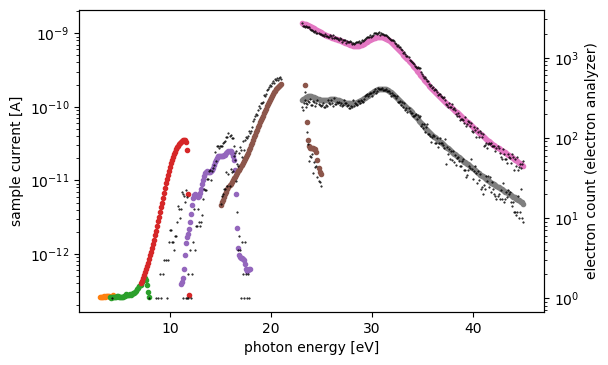

In [ ]:
mat_name = 'LM_thin_1_low'
mat_file_number = 83
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

LM_thin_1_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
LM_thin_1_low_df = LM_thin_1_low_df.drop(LM_thin_1_low_df[LM_thin_1_low_df.I_KB > 1e5].index) #delete outliers in current:
subtract_offsets(LM_thin_1_low_df,offsets_df)

fig, ax1 = plt.subplots(figsize=(6,4), dpi=100)
ax2 = ax1.twinx()

for i in range(8):
    criterion = LM_thin_1_low_df['reg_number'] == i
    pd_df = LM_thin_1_low_df.loc[criterion]
    ax1.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

for i in range(8):
    criterion = LM_thin_1_low_df['reg_number'] == i
    pd_df = LM_thin_1_low_df.loc[criterion]
    ax2.plot(pd_df['phot_E'],pd_df['I_KC'],'.',color="black",markersize=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('photon energy [eV]')
ax1.set_ylabel('sample current [A]')
ax2.set_ylabel('electron count (electron analyzer)')

material df:  685 
photodiode df: 339


Text(0, 0.5, 'Yield')

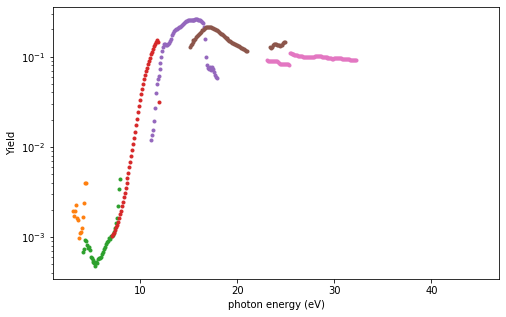

In [ ]:
compute_yield(mat_df=LM_thin_1_low_df,PD_df=PD_compare_fine_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=False)

figure(figsize=(8, 5))
for i in range(8):
    criterion = LM_thin_1_low_df['reg_number'] == i
    pd_df = LM_thin_1_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')

# LM Thin 1 High (Lunar Meteorite, Position 1)

Text(0, 0.5, 'electron count (electron analyzer)')

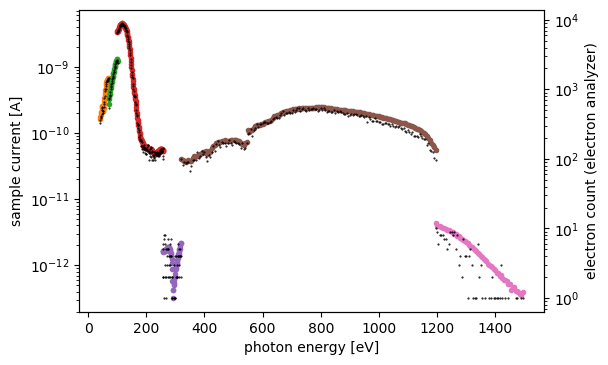

In [ ]:
mat_name = 'LM_thin_1_high'
mat_file_number = 73
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

LM_thin_1_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(LM_thin_1_high_df,offsets_df)

fig, ax1 = plt.subplots(figsize=(6,4), dpi=100)
ax2 = ax1.twinx()

for i in range(8):
    criterion = LM_thin_1_high_df['reg_number'] == i
    pd_df = LM_thin_1_high_df.loc[criterion]
    ax1.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

for i in range(8):
    criterion = LM_thin_1_high_df['reg_number'] == i
    pd_df = LM_thin_1_high_df.loc[criterion]
    ax2.plot(pd_df['phot_E'],pd_df['I_KC'],'.',color="black",markersize=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('photon energy [eV]')
ax1.set_ylabel('sample current [A]')
ax2.set_ylabel('electron count (electron analyzer)')

material df:  524 
photodiode df: 523


Text(0.5, 1.0, 'Lunar Meteorite 1 (thin, position 1) Yield')

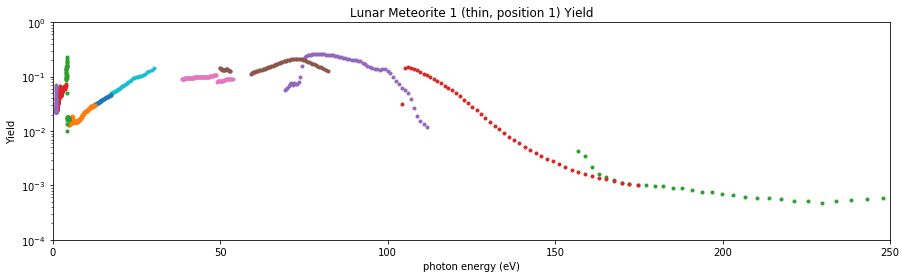

In [ ]:
compute_yield(mat_df=LM_thin_1_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=False)

figure(figsize=(15, 4))
for i in range(8):
    criterion = LM_thin_1_low_df['reg_number'] == i
    pd_df = LM_thin_1_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = LM_thin_1_high_df['reg_number'] == i
    pd_df = LM_thin_1_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')
plt.xlim(0,250)
plt.ylim(1e-4,1)
plt.title('Lunar Meteorite 1 (thin, position 1) Yield')

# LM Thin 2 (Lunar Meteorite, Position 2)

Text(0, 0.5, 'electron count (electron analyzer)')

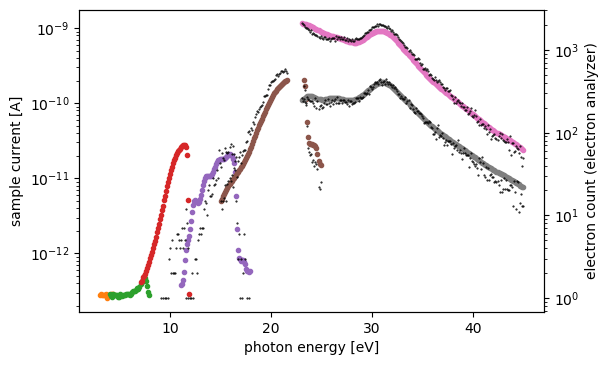

In [ ]:
mat_name = 'LM_thin_2_low'
mat_file_number = 82
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

LM_thin_2_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
LM_thin_2_low_df = LM_thin_2_low_df.drop(LM_thin_2_low_df[LM_thin_2_low_df.I_KB > 1e5].index) #delete outliers in current:
subtract_offsets(LM_thin_2_low_df,offsets_df)

fig, ax1 = plt.subplots(figsize=(6,4), dpi=100)
ax2 = ax1.twinx()

for i in range(8):
    criterion = LM_thin_2_low_df['reg_number'] == i
    pd_df = LM_thin_2_low_df.loc[criterion]
    ax1.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

for i in range(8):
    criterion = LM_thin_2_low_df['reg_number'] == i
    pd_df = LM_thin_2_low_df.loc[criterion]
    ax2.plot(pd_df['phot_E'],pd_df['I_KC'],'.',color="black",markersize=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('photon energy [eV]')
ax1.set_ylabel('sample current [A]')
ax2.set_ylabel('electron count (electron analyzer)')

material df:  692 
photodiode df: 339


Text(0, 0.5, 'Yield')

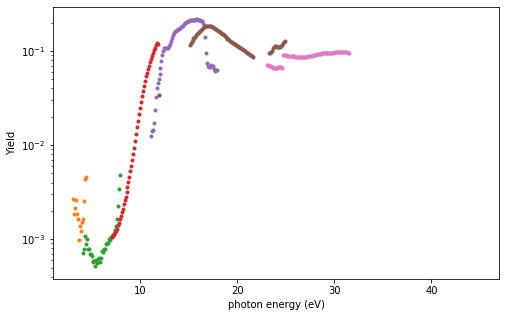

In [ ]:
compute_yield(mat_df=LM_thin_2_low_df,PD_df=PD_compare_fine_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=False)

figure(figsize=(8, 5))
for i in range(8):
    criterion = LM_thin_2_low_df['reg_number'] == i
    pd_df = LM_thin_2_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')

Text(0, 0.5, 'electron count (electron analyzer)')

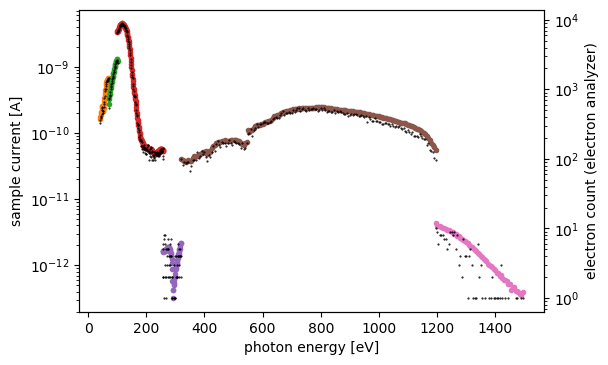

In [ ]:
mat_name = 'LM_thin_2_high'
mat_file_number = 73
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

LM_thin_2_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(LM_thin_2_high_df,offsets_df)

fig, ax1 = plt.subplots(figsize=(6,4), dpi=100)
ax2 = ax1.twinx()

for i in range(8):
    criterion = LM_thin_2_high_df['reg_number'] == i
    pd_df = LM_thin_2_high_df.loc[criterion]
    ax1.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

for i in range(8):
    criterion = LM_thin_2_high_df['reg_number'] == i
    pd_df = LM_thin_2_high_df.loc[criterion]
    ax2.plot(pd_df['phot_E'],pd_df['I_KC'],'.',color="black",markersize=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('photon energy [eV]')
ax1.set_ylabel('sample current [A]')
ax2.set_ylabel('electron count (electron analyzer)')

material df:  524 
photodiode df: 523


Text(0.5, 1.0, 'Lunar Meteorite 2 (thin, position 2) Yield')

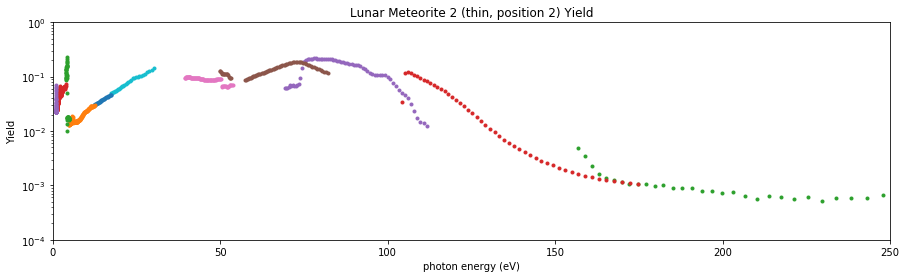

In [ ]:
compute_yield(mat_df=LM_thin_2_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=False)

figure(figsize=(15, 4))
for i in range(8):
    criterion = LM_thin_2_low_df['reg_number'] == i
    pd_df = LM_thin_2_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = LM_thin_2_high_df['reg_number'] == i
    pd_df = LM_thin_2_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')
plt.xlim(0,250)
plt.ylim(1e-4,1)
plt.title('Lunar Meteorite 2 (thin, position 2) Yield')

# LM Thick 1 (Lunar Meteorite, Position 1)

Text(0, 0.5, 'electron count (electron analyzer)')

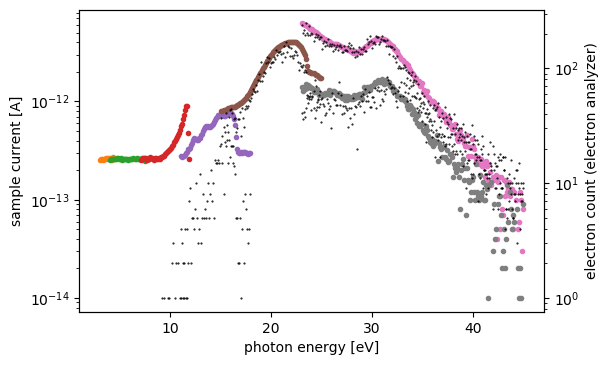

In [ ]:
mat_name = 'LM_thick_1_low'
mat_file_number = 85
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

LM_thick_1_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
LM_thick_1_low_df = LM_thick_1_low_df.drop(LM_thick_1_low_df[LM_thick_1_low_df.I_KB > 1e5].index) #delete outliers in current:
subtract_offsets(LM_thick_1_low_df,offsets_df)

fig, ax1 = plt.subplots(figsize=(6,4), dpi=100)
ax2 = ax1.twinx()

for i in range(8):
    criterion = LM_thick_1_low_df['reg_number'] == i
    pd_df = LM_thick_1_low_df.loc[criterion]
    ax1.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

for i in range(8):
    criterion = LM_thick_1_low_df['reg_number'] == i
    pd_df = LM_thick_1_low_df.loc[criterion]
    ax2.plot(pd_df['phot_E'],pd_df['I_KC'],'.',color="black",markersize=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('photon energy [eV]')
ax1.set_ylabel('sample current [A]')
ax2.set_ylabel('electron count (electron analyzer)')

material df:  708 
photodiode df: 339


Text(0, 0.5, 'Yield')

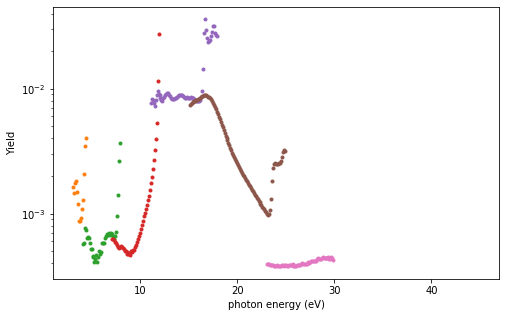

In [ ]:
compute_yield(mat_df=LM_thick_1_low_df,PD_df=PD_compare_fine_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=False)

figure(figsize=(8, 5))
for i in range(8):
    criterion = LM_thick_1_low_df['reg_number'] == i
    pd_df = LM_thick_1_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')

Text(0, 0.5, 'electron count (electron analyzer)')

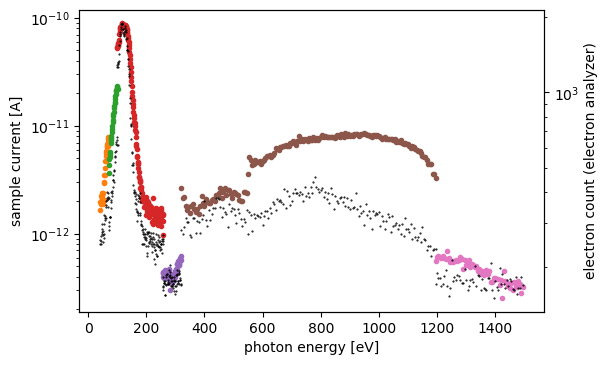

In [ ]:
mat_name = 'LM_thick_1_high'
mat_file_number = 66
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

LM_thick_1_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(LM_thick_1_high_df,offsets_df)

fig, ax1 = plt.subplots(figsize=(6,4), dpi=100)
ax2 = ax1.twinx()

for i in range(8):
    criterion = LM_thick_1_high_df['reg_number'] == i
    pd_df = LM_thick_1_high_df.loc[criterion]
    ax1.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

for i in range(8):
    criterion = LM_thick_1_high_df['reg_number'] == i
    pd_df = LM_thick_1_high_df.loc[criterion]
    ax2.plot(pd_df['phot_E'],pd_df['I_KC'],'.',color="black",markersize=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('photon energy [eV]')
ax1.set_ylabel('sample current [A]')
ax2.set_ylabel('electron count (electron analyzer)')

material df:  524 
photodiode df: 523


Text(0.5, 1.0, 'THICK Lunar Meteorite (position 1) Yield')

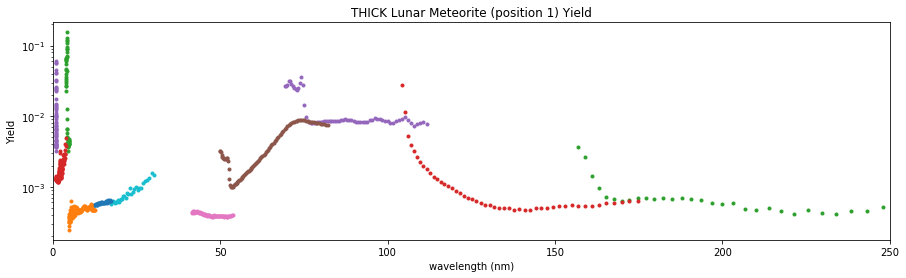

In [ ]:
compute_yield(mat_df=LM_thick_1_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=False)

figure(figsize=(15, 4))
for i in range(8):
    criterion = LM_thick_1_low_df['reg_number'] == i
    pd_df = LM_thick_1_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = LM_thick_1_high_df['reg_number'] == i
    pd_df = LM_thick_1_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('wavelength (nm)')
plt.ylabel('Yield')
plt.xlim(0,250)
plt.title('THICK Lunar Meteorite (position 1) Yield')

# LM Thick 2 (Lunar Meteorite, Position 2)

Text(0, 0.5, 'electron count (electron analyzer)')

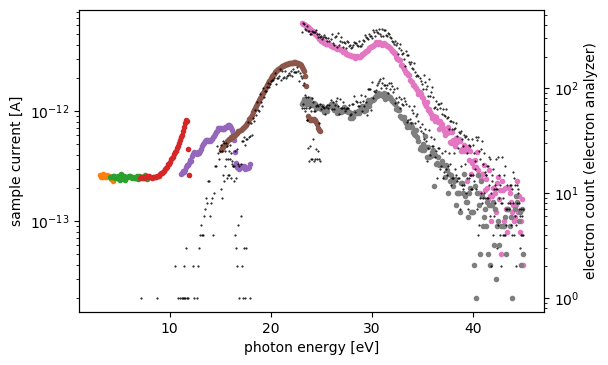

In [ ]:
mat_name = 'LM_thick_2_low'
mat_file_number = 84
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

LM_thick_2_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
LM_thick_2_low_df = LM_thick_2_low_df.drop(LM_thick_2_low_df[LM_thick_2_low_df.I_KB > 1e5].index) #delete outliers in current:
subtract_offsets(LM_thick_2_low_df,offsets_df)

fig, ax1 = plt.subplots(figsize=(6,4), dpi=100)
ax2 = ax1.twinx()

for i in range(8):
    criterion = LM_thick_2_low_df['reg_number'] == i
    pd_df = LM_thick_2_low_df.loc[criterion]
    ax1.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

for i in range(8):
    criterion = LM_thick_2_low_df['reg_number'] == i
    pd_df = LM_thick_2_low_df.loc[criterion]
    ax2.plot(pd_df['phot_E'],pd_df['I_KC'],'.',color="black",markersize=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('photon energy [eV]')
ax1.set_ylabel('sample current [A]')
ax2.set_ylabel('electron count (electron analyzer)')

material df:  708 
photodiode df: 339


Text(0, 0.5, 'Yield')

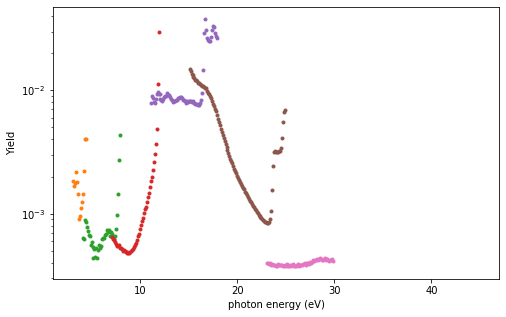

In [ ]:
compute_yield(mat_df=LM_thick_2_low_df,PD_df=PD_compare_fine_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="aug",subtract_offset=False)

figure(figsize=(8, 5))
for i in range(8):
    criterion = LM_thick_2_low_df['reg_number'] == i
    pd_df = LM_thick_2_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')

Text(0, 0.5, 'electron count (electron analyzer)')

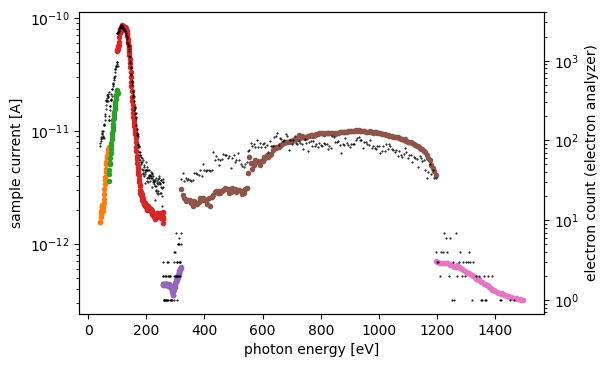

In [ ]:
mat_name = 'LM_thick_2_high'
mat_file_number = 78
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

LM_thick_2_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(LM_thick_2_high_df,offsets_df)

fig, ax1 = plt.subplots(figsize=(6,4), dpi=100)
ax2 = ax1.twinx()

for i in range(8):
    criterion = LM_thick_2_high_df['reg_number'] == i
    pd_df = LM_thick_2_high_df.loc[criterion]
    ax1.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

for i in range(8):
    criterion = LM_thick_2_high_df['reg_number'] == i
    pd_df = LM_thick_2_high_df.loc[criterion]
    ax2.plot(pd_df['phot_E'],pd_df['I_KC'],'.',color="black",markersize=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('photon energy [eV]')
ax1.set_ylabel('sample current [A]')
ax2.set_ylabel('electron count (electron analyzer)')

material df:  524 
photodiode df: 523


Text(0.5, 1.0, 'THICK Lunar Meteorite (position 2) Yield')

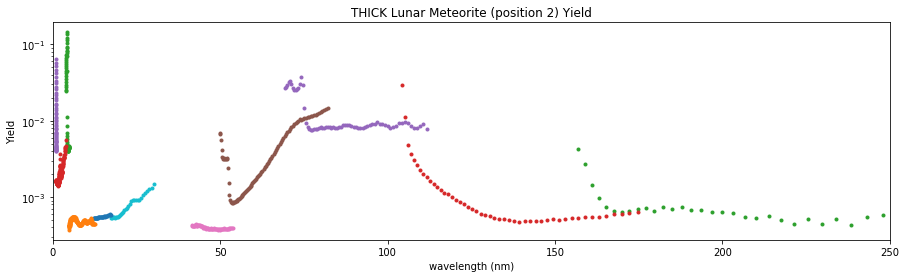

In [ ]:
compute_yield(mat_df=LM_thick_2_high_df,PD_df=PD_high_df,threshs_aug=[thresh_1_aug,thresh_2_aug],threshs_march=[thresh_1_march,thresh_2_march],pd_version="march",subtract_offset=False)

figure(figsize=(15, 4))

for i in range(8):
    criterion = LM_thick_2_low_df['reg_number'] == i
    pd_df = LM_thick_2_low_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
for i in range(8):
    criterion = LM_thick_2_high_df['reg_number'] == i
    pd_df = LM_thick_2_high_df.loc[criterion]
    plt.plot(convert_eV_to_nm(pd_df['phot_E']),pd_df['Yield'],'.')
plt.yscale('log')
plt.xlabel('wavelength (nm)')
plt.ylabel('Yield')
plt.xlim(0,250)
plt.title('THICK Lunar Meteorite (position 2) Yield')